# Initialization

In [1]:
%cd ../covid_households
import recipes
import numpy as np

/Users/thayer/covid_households/covid_households


In [2]:
import pandas as pd
pd.set_option('mode.chained_assignment', 'raise')

In [3]:
do_rebuild = False
import model_inputs
import rebuild
if do_rebuild:
    s80_axis = np.linspace(0.02, 0.80, 40)
    p80_axis = np.linspace(0.02, 0.80, 40)
    sar_axis = np.linspace(0.01, 0.60, 60)
    axes_by_key = {'s80':s80_axis, 'p80':p80_axis, 'SAR':sar_axis}
    big_region = recipes.SimulationRegion(axes_by_key, model_inputs.S80_P80_SAR_Inputs)

    small_s80_axis = np.linspace(0.20, 0.80, 31)
    small_p80_axis = np.linspace(0.20, 0.80, 31)
    small_sar_axis = np.linspace(0.10, 0.60, 51)
    small_axes_by_key = {'s80':small_s80_axis, 'p80':small_p80_axis, 'SAR':small_sar_axis}
    small_region = recipes.SimulationRegion(small_axes_by_key, model_inputs.S80_P80_SAR_Inputs)

    results = rebuild.rebuild(rebuild.gillespie_completed_dirs, rebuild.gillespie_from_parts_dirs, '/Users/thayer/covid_households/new_parameters/gillespie-s80-p80-SAR/beta_corrections', overwrite_dirs=rebuild.gillespie_overwrite_dirs, check_region=big_region)
    #results = rebuild.rebuild(rebuild.tweaked_dprob_completed_dirs, rebuild.tweaked_dprob_from_parts_dirs, '/Users/thayer/covid_households/new_parameters/s80-p80-SAR-sizes-2-8-tweaked-dprobability', check_region=small_region)
else:
    #results = recipes.Results.load('/Users/thayer/covid_households/new_parameters/s80-p80-SAR-sizes-2-8-tweaked-dprobability')
    #results = recipes.Results.load('/Users/thayer/covid_households/new_parameters/gillespie-s80-p80-SAR')
    results = recipes.Results.load('/Users/thayer/covid_households/new_parameters/gillespie-s80-p80-SAR/beta_corrections')

In [4]:
results.df.loc[0.02, 0.04, 0.11]

count  sus_variance  inf_variance   beta  \
size infections                                              
2    1           190203        1000.0       827.865  0.743   
     2             9797        1000.0       827.865  0.743   
3    1           179966        1000.0       827.865  0.743   
     2            14351        1000.0       827.865  0.743   
     3             5683        1000.0       827.865  0.743   
4    1           170502        1000.0       827.865  0.743   
     2            16568        1000.0       827.865  0.743   
     3             8499        1000.0       827.865  0.743   
     4             4431        1000.0       827.865  0.743   
5    1           162370        1000.0       827.865  0.743   
     2            17334        1000.0       827.865  0.743   
     3             9695        1000.0       827.865  0.743   
     4             6720        1000.0       827.865  0.743   
     5             3881        1000.0       827.865  0.743   
6    1           154884        1000.0       827.865  0.743   
     2            17707        1000.0       827.865  0.743   
     3            10084        1000.0       827.865  0.743   
     4             7757        1000.0       827.865  0.743   
     5             5928        1000.0       827.865  0.743   
     6             3640        1000.0       827.865  0.743   
7    1           147967        1000.0       827.865  0.743   
     2            17723        1000.0       827.865  0.743   
     3            10161        1000.0       827.865  0.743   
     4             8051        1000.0       827.865  0.743   
     5             6926        1000.0       827.865  0.743   
     6             5649        1000.0       827.865  0.743   
     7             3523        1000.0       827.865  0.743   
8    1           142192        1000.0       827.865  0.743   
     2            17048        1000.0       827.865  0.743   
     3             9966        1000.0       827.865  0.743   
     4             7915        1000.0       827.865  0.743   
     5             7436        1000.0       827.865  0.743   
     6             6647        1000.0       827.865  0.743   
     7             5495        1000.0       827.865  0.743   
     8             3301        1000.0       827.865  0.743   

                 inf_constant_value  sus_constant_value  
size infections                                          
2    1                          NaN                 NaN  
     2                          NaN                 NaN  
3    1                          NaN                 NaN  
     2                          NaN                 NaN  
     3                          NaN                 NaN  
4    1                          NaN                 NaN  
     2                          NaN                 NaN  
     3                          NaN                 NaN  
     4                          NaN                 NaN  
5    1                          NaN                 NaN  
     2                          NaN                 NaN  
     3                          NaN                 NaN  
     4                          NaN                 NaN  
     5                          NaN                 NaN  
6    1                          NaN                 NaN  
     2                          NaN                 NaN  
     3                          NaN                 NaN  
     4                          NaN                 NaN  
     5                          NaN                 NaN  
     6                          NaN                 NaN  
7    1                          NaN                 NaN  
     2                          NaN                 NaN  
     3                          NaN                 NaN  
     4                          NaN                 NaN  
     5                          NaN                 NaN  
     6                          NaN                 NaN  
     7                          NaN                 NaN  
8    1                          NaN      

In [5]:
results.find_frequencies(inplace=True)

s80   p80   SAR   size  infections
0.02  0.02  0.01  2     1             0.997565
                        2             0.002435
                  3     1             0.993942
                        2             0.005480
                        3             0.000577
                                        ...   
0.80  0.80  0.60  7     6             0.000035
                        7             0.987150
                  8     1             0.007005
                        2             0.000075
                        8             0.992920
Name: count, Length: 3356159, dtype: float64

# Violin figures

`null_freqs` represents the frequencies we observe in the absence of heterogeneity. We use it to calculate the MLE along the restriction where heterogeneity is not present.

In [6]:
freq = results.df['frequency']
s80_l = freq.index.get_level_values(0)
p80_l = freq.index.get_level_values(1)

null_freqs = freq[(s80_l == 0.8) & (p80_l == 0.8)]
null_freqs

s80  p80  SAR   size  infections
0.8  0.8  0.01  2     1             0.989690
                      2             0.010310
                3     1             0.979630
                      2             0.019695
                      3             0.000675
                                      ...   
          0.60  7     6             0.000035
                      7             0.987150
                8     1             0.007005
                      2             0.000075
                      8             0.992920
Name: frequency, Length: 2060, dtype: float64

In [7]:
def make_mles(logl, population, parameter_set, population_name=None):
    """Takes the log likelihood surface for each configuration and returns the MLEs (one for each trial).

    Args:
        logl (Pandas.DataFrame): the loglikelihood surface. Indexed by at least `trial` which represent different observations
        population (dict): a dictionary of household size --> number of households.
        parameter_set (tuple): the value of each parameter that in fact produced the simulated data

    Returns:
        Pandas.DataFrame: a dataframe of MLE values with one column for each parameter inferred
    """
    fits = logl.groupby('trial').idxmax()
    fits = pd.DataFrame(fits.tolist())
    new_names = []
    for name in logl.index.names:
        name = name if name == 'trial' else 'MLE_' + name
        new_names.append(name)
    fits.columns = new_names
    fits.set_index('trial')

    fits['sample size'] = sum([k*v for k,v in population.items()])
    if population_name is not None:
        fits['population mix'] = population_name
    else:
        fits['population mix'] = [tuple(population.keys()) for i in range(len(fits))]
    fits ['parameters'] = [parameter_set] * len(fits)
    return fits

Choose the different combinations of parameters / sample sizes / household sizes to try.

In [8]:
%cd /Users/thayer/covid_households/covid_households
import likelihood
sample_sizes = [1000, 5000, 10000]
#parameter_sets = [(0.5, 0.5, 0.25), (0.3, 0.3, 0.25), (0.8, 0.4, 0.25), (0.4, 0.8, 0.25), (0.5, 0.5, 0.35), (0.3, 0.3, 0.35), (0.8, 0.4, 0.35), (0.4, 0.8, 0.35)]
#parameter_sets = [(0.5, 0.5, 0.35), (0.3, 0.3, 0.35), (0.8, 0.4, 0.35), (0.4, 0.8, 0.35)]
parameter_sets = [(0.2, 0.2, 0.20), (0.8, 0.2, 0.20), (0.2, 0.8, 0.20)]

#   Two  | Three	 Four     Five    Six    Seven or more
# 2021
# 45,515 | 19,523 | 16,098 | 7,577 | 2,635 |     1,611
# https://www.census.gov/data/tables/time-series/demo/families/households.html
# Let's take households of size > 2 and assume that 'seven or more' --> equal mix of 7 and 8
American_households_size_ge_3 = (19523 + 16098 + 7577 + 2635 + 1611)
America_total = {3:19523, 4:16098, 5:7577, 6:2635, 7:1611//2, 8:1611//2}
America_households_total = np.sum([v for v in America_total.values()])
named_populations = {'America_census':{k:v/America_households_total for k,v in America_total.items()}}
population_descriptions = {'America_census': 'divided in proportion to American households of size >=3'}


# UN data: https://www.un.org/development/desa/pd/data/household-size-and-composition

# A few other countries
# Percent 1 | 2-3 | 4-5 | 6+
# Philippines [2017] (average size = 4.23)
# 9.18	30.05	36.82	23.95
philippines_percents = [9.18, 30.05, 36.82, 23.95]
# Guatemala [2015] (average size = 5.23)
# 4.33	26.57	37.51	31.60
guatemala_percents = [4.33, 26.57, 37.51, 31.60]
guatemala_average = 5.23
# US [2015] (average size = 2.49)
# 27.89	49.49	18.81	3.81
us_percents = [27.89, 49.49, 18.81, 3.81]
# Mexico [2015] (Average size 3.74)
# 10.08	37.68	37.75	14.49
mexico_percents = [10.08, 37.68, 37.75, 14.49]

percent_buckets_left_side = [1, 2, 4, 6]
percent_buckets_right_side = [1, 3, 5, 9]

# Let's be dumb about it and just assume that you are evenly mixed within the bucket and that 6+ goes from 6-8.
# Don't anchor to the average, just calculate the residual

buckets = [(1,1), (2,3), (4,5), (6,8)]
def uniform_buckets(percents, left_cutoff=None):
    np_population = np.zeros(10)
    for i,bucket in enumerate(buckets):
        left, right = bucket
        average_percent = percents[i] / (right - left + 1)
        for size in range(left, right+1):
            np_population[size] = average_percent
    if left_cutoff is not None:
        np_population[:left_cutoff] = 0
        remaining_percent = np.sum(np_population)
        np_population = np_population * 100 / (remaining_percent)
    population = {}
    for size, percent in enumerate(np_population):
        if percent == 0:
            continue
        population[size] = percent/100
    return population

named_populations.update({
    'America_UN':uniform_buckets(us_percents, left_cutoff=3),
    'Mexico':uniform_buckets(mexico_percents, left_cutoff=3),
    'Philippines':uniform_buckets(philippines_percents, left_cutoff=3),
    'Guatemala':uniform_buckets(guatemala_percents, left_cutoff=3),
})

population_descriptions.update({
    'America_UN':'US households size >= 3 estimated from UN',
    'Mexico':'Mexican households size >= 3 estimated from UN',
    'Philippines':'Philippine households size >= 3 estimated from UN',
    'Guatemala':'Guatemalan households size >= 3 estimated from UN'
})

population_mixes = ['America_census']
#population_mixes = [(4,5,6,7,8), 'America_UN', 'Mexico', 'Philippines', 'Guatemala']
#population_mixes = [(8,), (4,), 'Guatemala']#, 'America_census', 'Guatemala']
#population_mixes = [(2,), (3,), (4,), (5,), (6,), (7,), (8,)]

/Users/thayer/covid_households/covid_households


Run the fits at all the combinations (create the population sample using statistical resampling — not forward simulation). Aggregate fits against the full surface in `fits_dfs` and the fits on the restriction that there is no heterogeneity in `null_hypoth_fits_dfs`.

In [9]:
trials = 1000

# a hypothesis is a theory about which parameters are involved. fits will be done separately for each hypothesis
hypotheses = {
    'all': ['s80', 'p80', 'SAR'],
    'SAR and infectivity vary': ['p80', 'SAR'],
    #'SAR and susceptibility vary': ['s80', 'SAR'],
    'null hypothesis': ['SAR'],
}

def restrict_parameters(base_results, included_parameters):
    freqs = base_results.df['frequency'].copy()

    for parameter in set(base_results.metadata.parameters) - set(included_parameters):
        if parameter not in ['s80', 'p80']:
            raise ValueError("can't exclude SAR as it has no default hypothesis.")
        parameter_level = freqs.index.get_level_values(base_results.metadata.parameters.index(parameter))
        freqs = freqs[(parameter_level == 0.8)]

    return freqs


frequencies_by_hypothesis = {k: restrict_parameters(results, included_parameters) for k,included_parameters in hypotheses.items()}
from collections import defaultdict
fit_collections = defaultdict(list)


In [10]:
for sample_size in sample_sizes:
    for population_mix in population_mixes:
        population_name = None
        if isinstance(population_mix, str):
            population_name = population_mix
            population = named_populations[population_mix]
            population = {k:int(np.round((v * sample_size)//k)) for k,v in population.items()}
            print(population)
        else:
            population_per_size = sample_size // len(population_mix)
            population = {s:population_per_size//s for s in population_mix}
            print(population)
        for parameter_set in parameter_sets:
            print(parameter_set, population)
            samples = results.resample(parameter_set, population, trials=trials)
            for hypothesis_name, hypothesis_frequencies in frequencies_by_hypothesis.items():
                logl = likelihood.logl_from_frequencies_and_counts(hypothesis_frequencies, samples['count'], results.metadata.parameters)
                fits = make_mles(logl, population, parameter_set, population_name=population_name)

                normalized_probability = logl.groupby('trial').apply(lambda g: likelihood.normalize_probability(g))
                confidence_masks = normalized_probability.groupby('trial').apply(lambda g: likelihood.find_confidence_mask(g)).astype('bool')
                confidence_grouped = confidence_masks.groupby('trial')
                p80_confidence_intervals = confidence_grouped.apply(lambda g: likelihood.confidence_interval_from_confidence_mask(g, 'p80', include_endpoints=True))
                s80_confidence_intervals = confidence_grouped.apply(lambda g: likelihood.confidence_interval_from_confidence_mask(g, 's80', include_endpoints=True))
                SAR_confidence_intervals = confidence_grouped.apply(lambda g: likelihood.confidence_interval_from_confidence_mask(g, 'SAR', include_endpoints=True))

                fits['p80_interval'] = (p80_confidence_intervals)
                fits['s80_interval'] = (s80_confidence_intervals)
                fits['SAR_interval'] = (SAR_confidence_intervals)
                fits['written sample size'] = sample_size
                fit_collections[hypothesis_name].append(fits)

{3: 137, 4: 84, 5: 31, 6: 9, 7: 2, 8: 2}
(0.2, 0.2, 0.2) {3: 137, 4: 84, 5: 31, 6: 9, 7: 2, 8: 2}
(0.8, 0.2, 0.2) {3: 137, 4: 84, 5: 31, 6: 9, 7: 2, 8: 2}
(0.2, 0.8, 0.2) {3: 137, 4: 84, 5: 31, 6: 9, 7: 2, 8: 2}
{3: 685, 4: 424, 5: 159, 6: 46, 7: 12, 8: 10}
(0.2, 0.2, 0.2) {3: 685, 4: 424, 5: 159, 6: 46, 7: 12, 8: 10}
(0.8, 0.2, 0.2) {3: 685, 4: 424, 5: 159, 6: 46, 7: 12, 8: 10}
(0.2, 0.8, 0.2) {3: 685, 4: 424, 5: 159, 6: 46, 7: 12, 8: 10}
{3: 1371, 4: 848, 5: 319, 6: 92, 7: 24, 8: 21}
(0.2, 0.2, 0.2) {3: 1371, 4: 848, 5: 319, 6: 92, 7: 24, 8: 21}
(0.8, 0.2, 0.2) {3: 1371, 4: 848, 5: 319, 6: 92, 7: 24, 8: 21}
(0.2, 0.8, 0.2) {3: 1371, 4: 848, 5: 319, 6: 92, 7: 24, 8: 21}


Combine results into single dfs.

In [11]:
fits = {} 
for hypothesis_name, fit_dfs in fit_collections.items():
    fit_df = pd.concat(fit_dfs)
    fits[hypothesis_name] = fit_df
    
null_fit_df = fits['null hypothesis']
fit_df = fits['all']
#fit_df = fits['SAR and infectivity vary']

The cell below will plot violins for each parameter over a single population.

<Figure size 432x288 with 0 Axes>

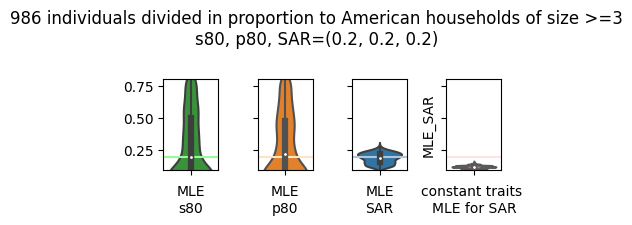

<Figure size 432x288 with 0 Axes>

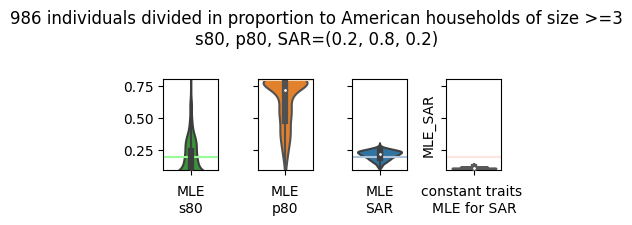

<Figure size 432x288 with 0 Axes>

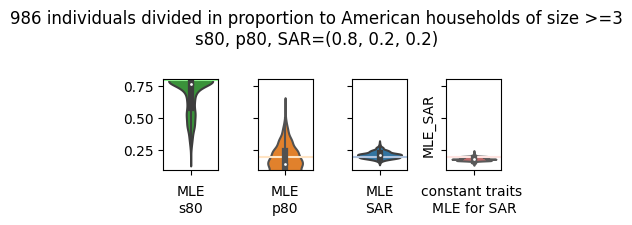

<Figure size 432x288 with 0 Axes>

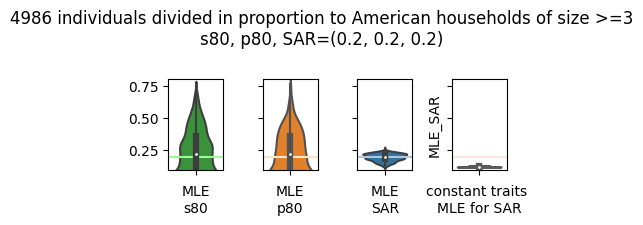

<Figure size 432x288 with 0 Axes>

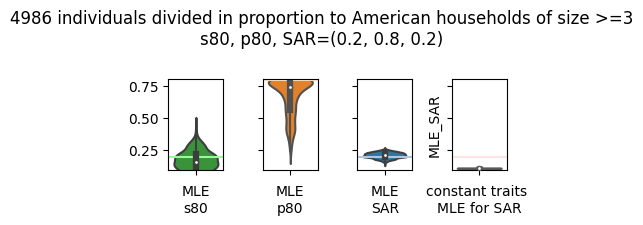

<Figure size 432x288 with 0 Axes>

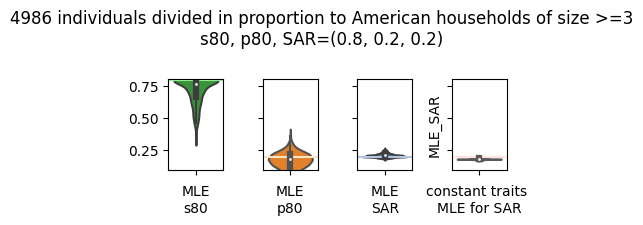

<Figure size 432x288 with 0 Axes>

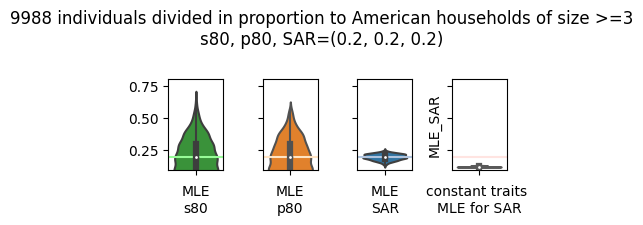

<Figure size 432x288 with 0 Axes>

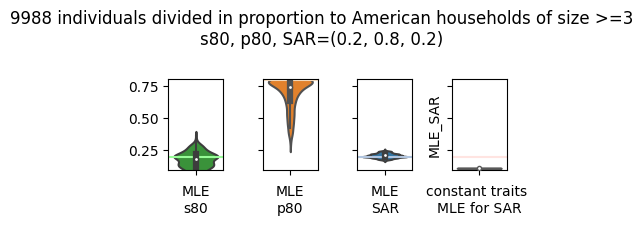

<Figure size 432x288 with 0 Axes>

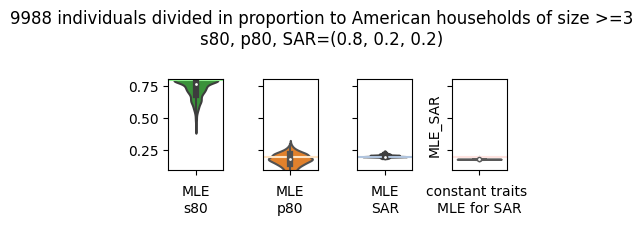

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
plt.close('all')


dpi = 100
save_figs = False

fig_sizes = {'small':(4,2.25), 'big':(8,4.5)}
chosen_size = 'small'

#%matplotlib agg
min_dict = {0.6: 0.3, 0.4:0.10, 0.5: 0.15, 0.8: 0.5}
max_dict = {0.6: 0.8, 0.4:0.65, 0.5: 0.8, 0.8: 0.8}
colors = ['tab:green', 'tab:orange', 'tab:blue']
axline_colors = ['palegreen', 'bisque', 'lightsteelblue']
xlabels = ['MLE\ns80', 'MLE\np80', 'MLE\nSAR', 'constant traits \nMLE for SAR']
grouping =['population mix', 'sample size', 'parameters']

for k,g in fit_df.groupby(grouping):
    plt.figure()
    fig, axes = plt.subplots(1,4, dpi=dpi, sharey=True, figsize=fig_sizes[chosen_size])

    population_mix, sample_size, parameters = k
    population_name = None
    if isinstance(population_mix, str):
        population_name = population_mix
        description = population_descriptions[population_mix]
    else:
        description = 'equally mixed'
    if population_name:
        plt.suptitle(f"{sample_size} individuals {description}\ns80, p80, SAR={parameters}")
    else:
        plt.suptitle(f"{sample_size} individuals {description} among size {population_mix} hhs. \ns80, p80, SAR={parameters}")
    i = 0
    for c in g.columns:
        if 'MLE' not in c:
            continue
        if 's80' in c or 'p80' in c:
            parameter_index = 0 if 's80' in c else 1
            #mi, ma = min_dict[parameters[parameter_index]], max_dict[parameters[parameter_index]]
            mi, ma = 0.1, 0.8
            axes[i].set_ylim(mi, ma)
        if 'SAR' in c:
            pass
            #axes[i].set_ylim(0.1, 0.5)
            axes[i].set_ylim(0.1, 0.8)
        if parameters[i] == 0.8:
            axes[i].axhline(0.795, color=axline_colors[i])
        else:
            axes[i].axhline(parameters[i], color=axline_colors[i])
        sns.violinplot(y=c, data=g, ax=axes[i], orient="v", color=colors[i])
        axes[i].set(xlabel=xlabels[i], ylabel='')
        i += 1
    null_fit_slice = null_fit_df.groupby(['population mix', 'sample size', 'parameters']).get_group(k)
    #axes[3].set_ylim(0.1, 0.5)
    axes[3].set_ylim(0.1, 0.8)
    # plot the true SAR on the null hypothesis SAR
    axes[3].axhline(parameters[2], color='mistyrose')
    axes[3].set(xlabel=xlabels[3], ylabel='')
    sns.violinplot(y=null_fit_slice['MLE_SAR'], data=null_fit_slice, ax=axes[3], orient="v", color='indianred')
    #axes[3].set(ylabel='MLE of SAR assuming no heterogeneity')
    fig.tight_layout()
    if save_figs:
        plt.savefig(os.path.join('/Users/thayer/covid_households/batched_figs', f'{k}' + '.jpg'))

The cell below will plot violins for all the parameters over a variety of different populations.

<Figure size 432x288 with 0 Axes>

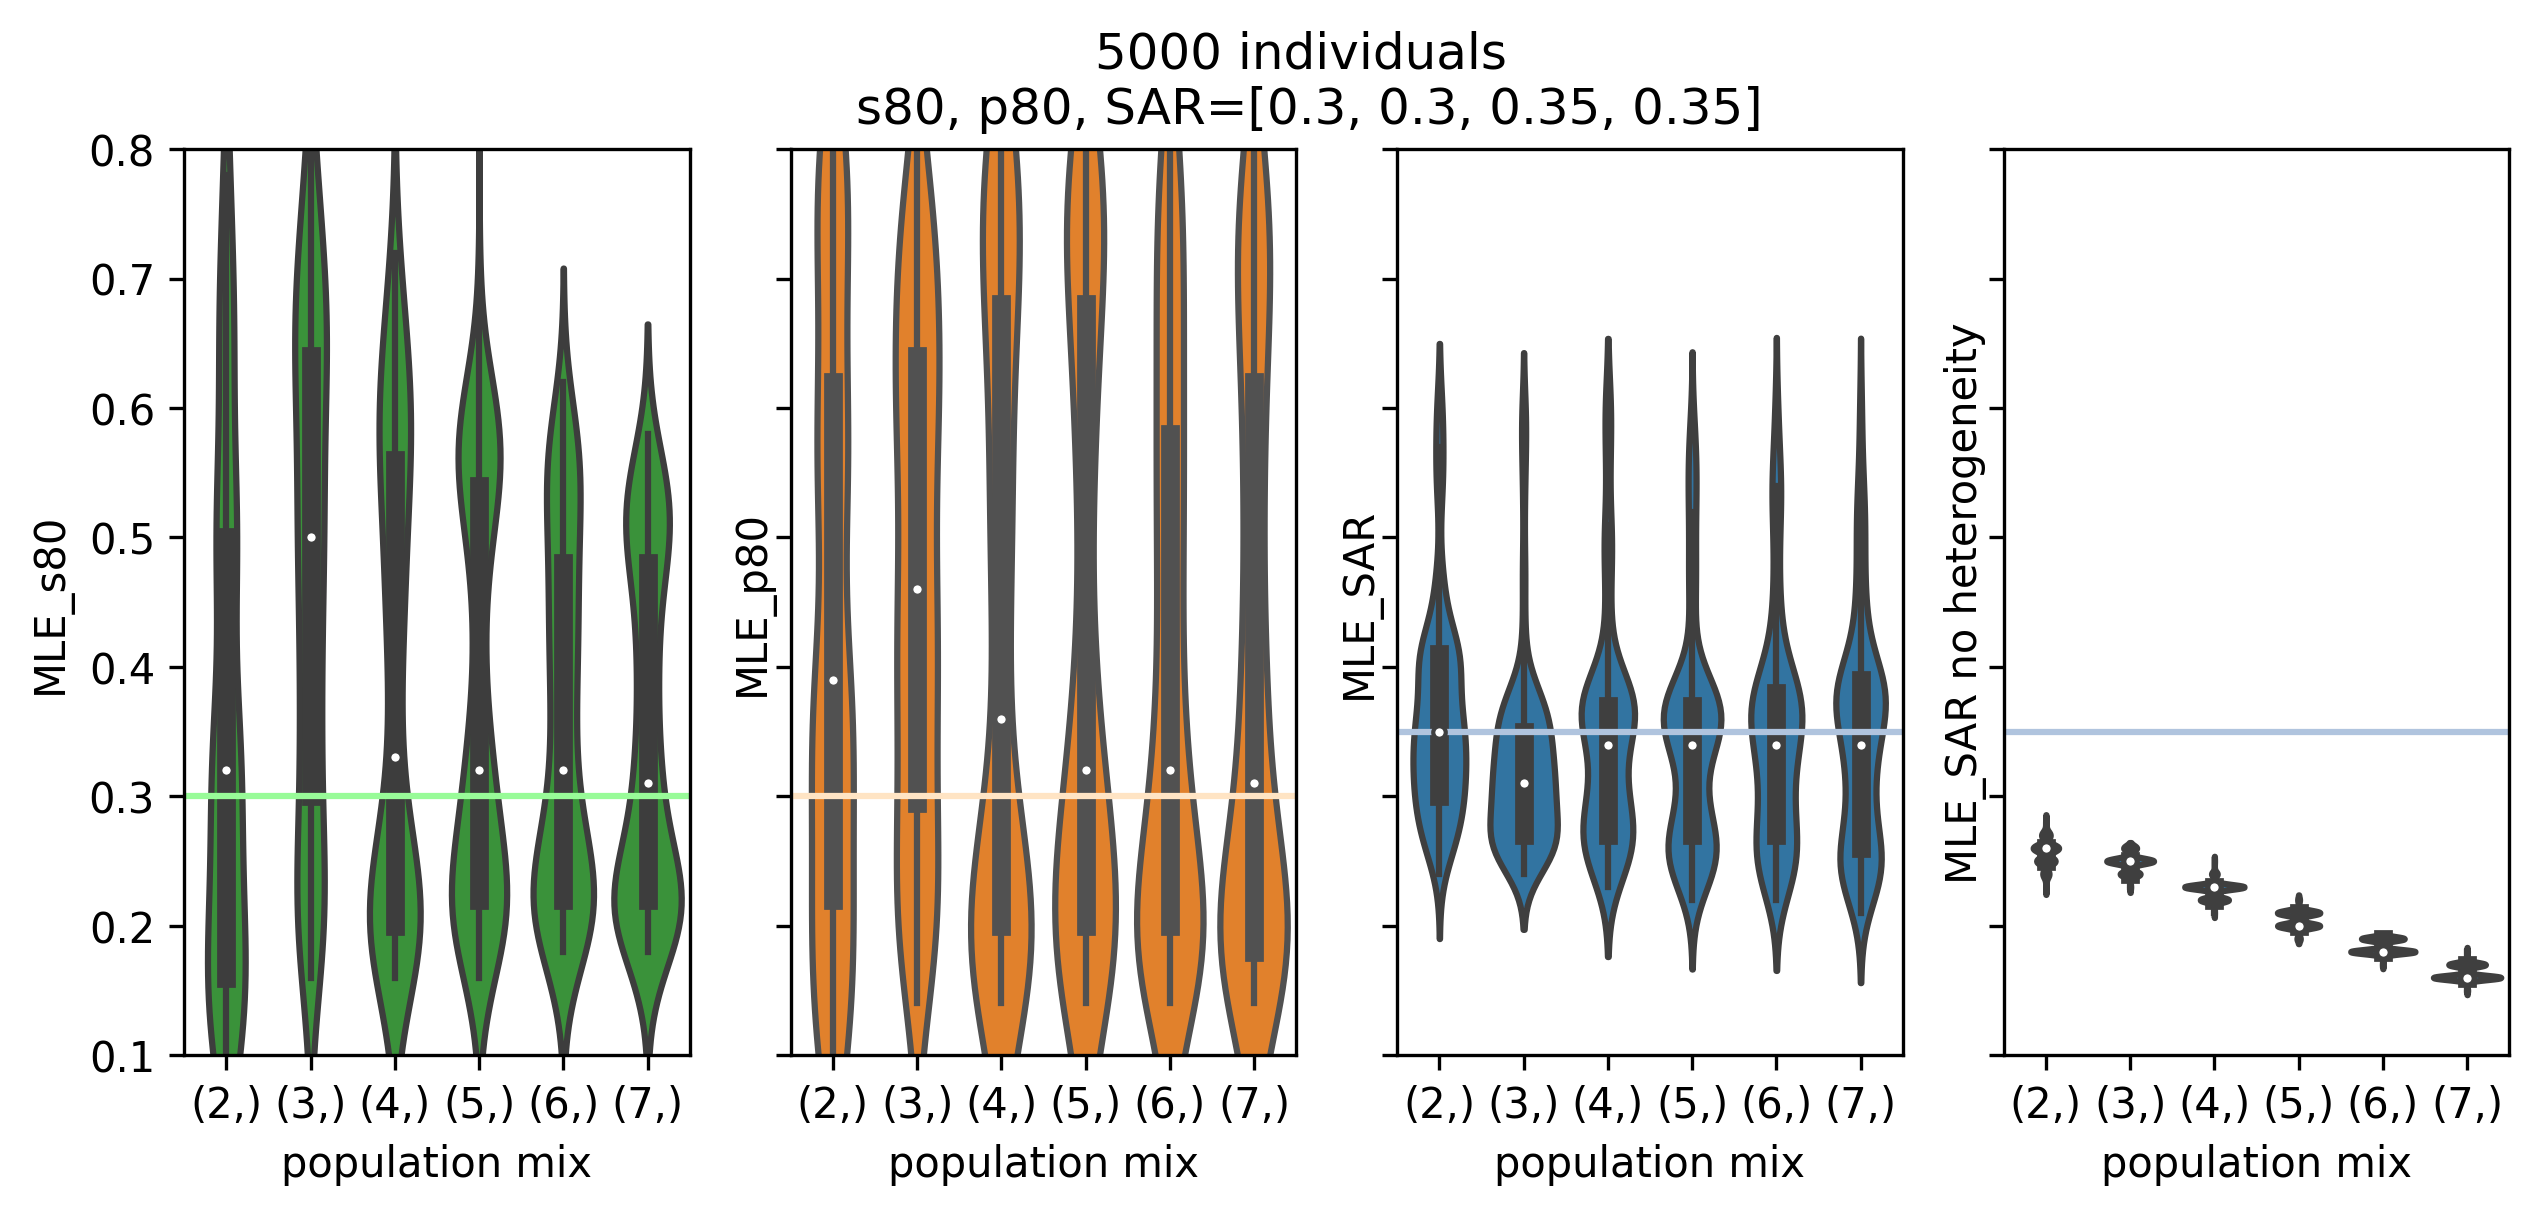

<Figure size 432x288 with 0 Axes>

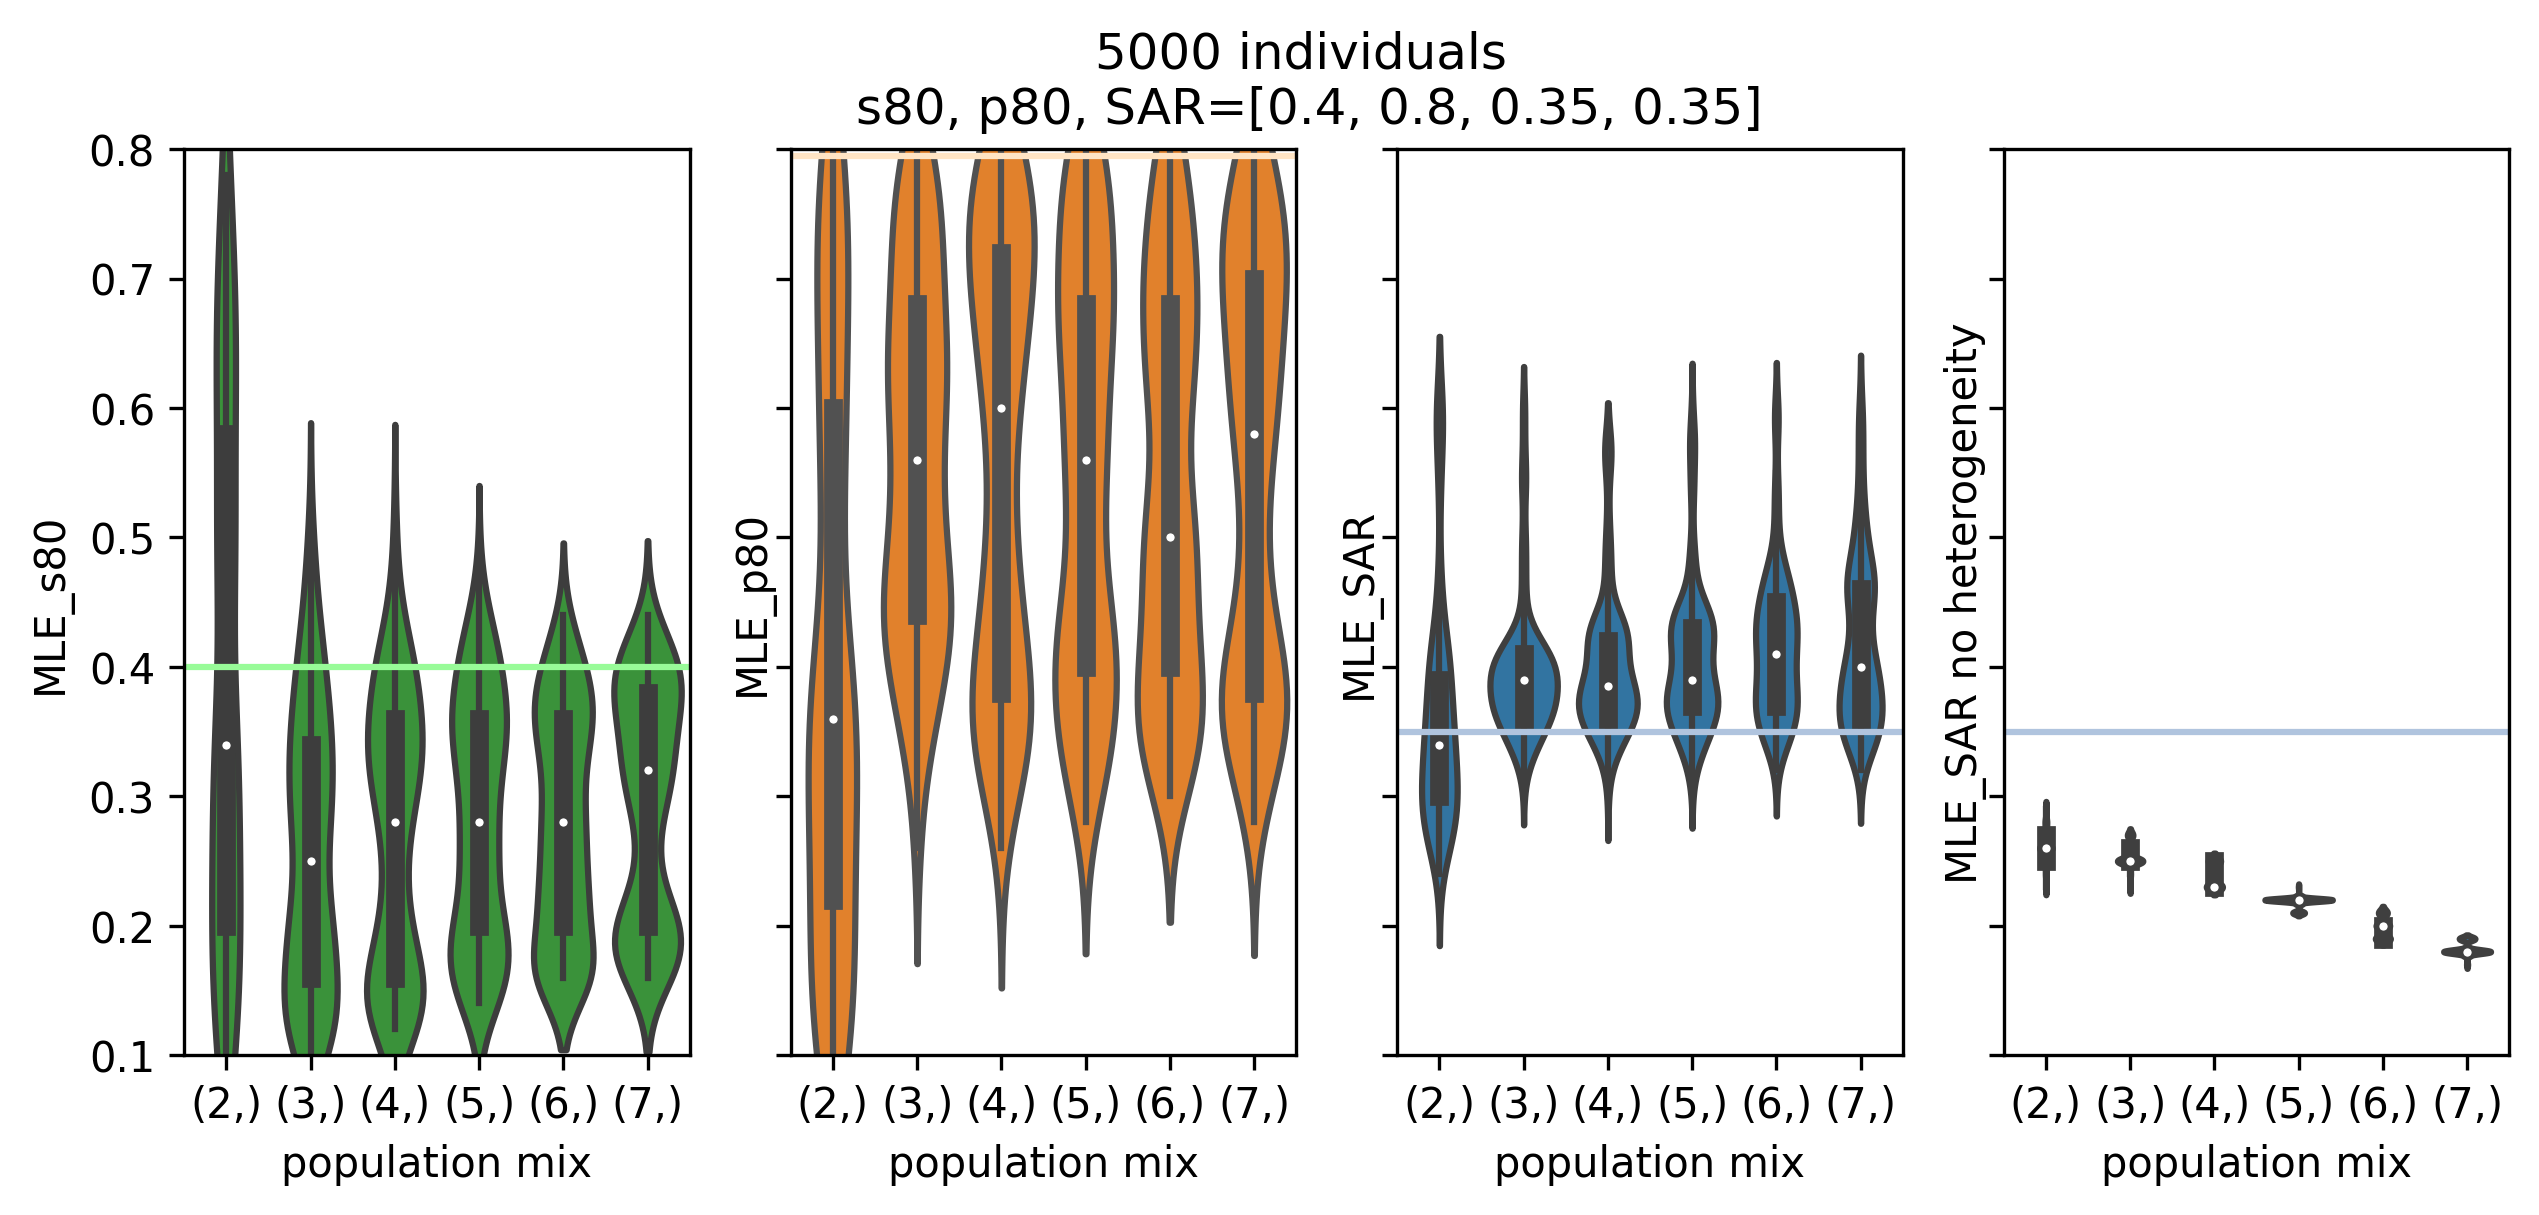

<Figure size 432x288 with 0 Axes>

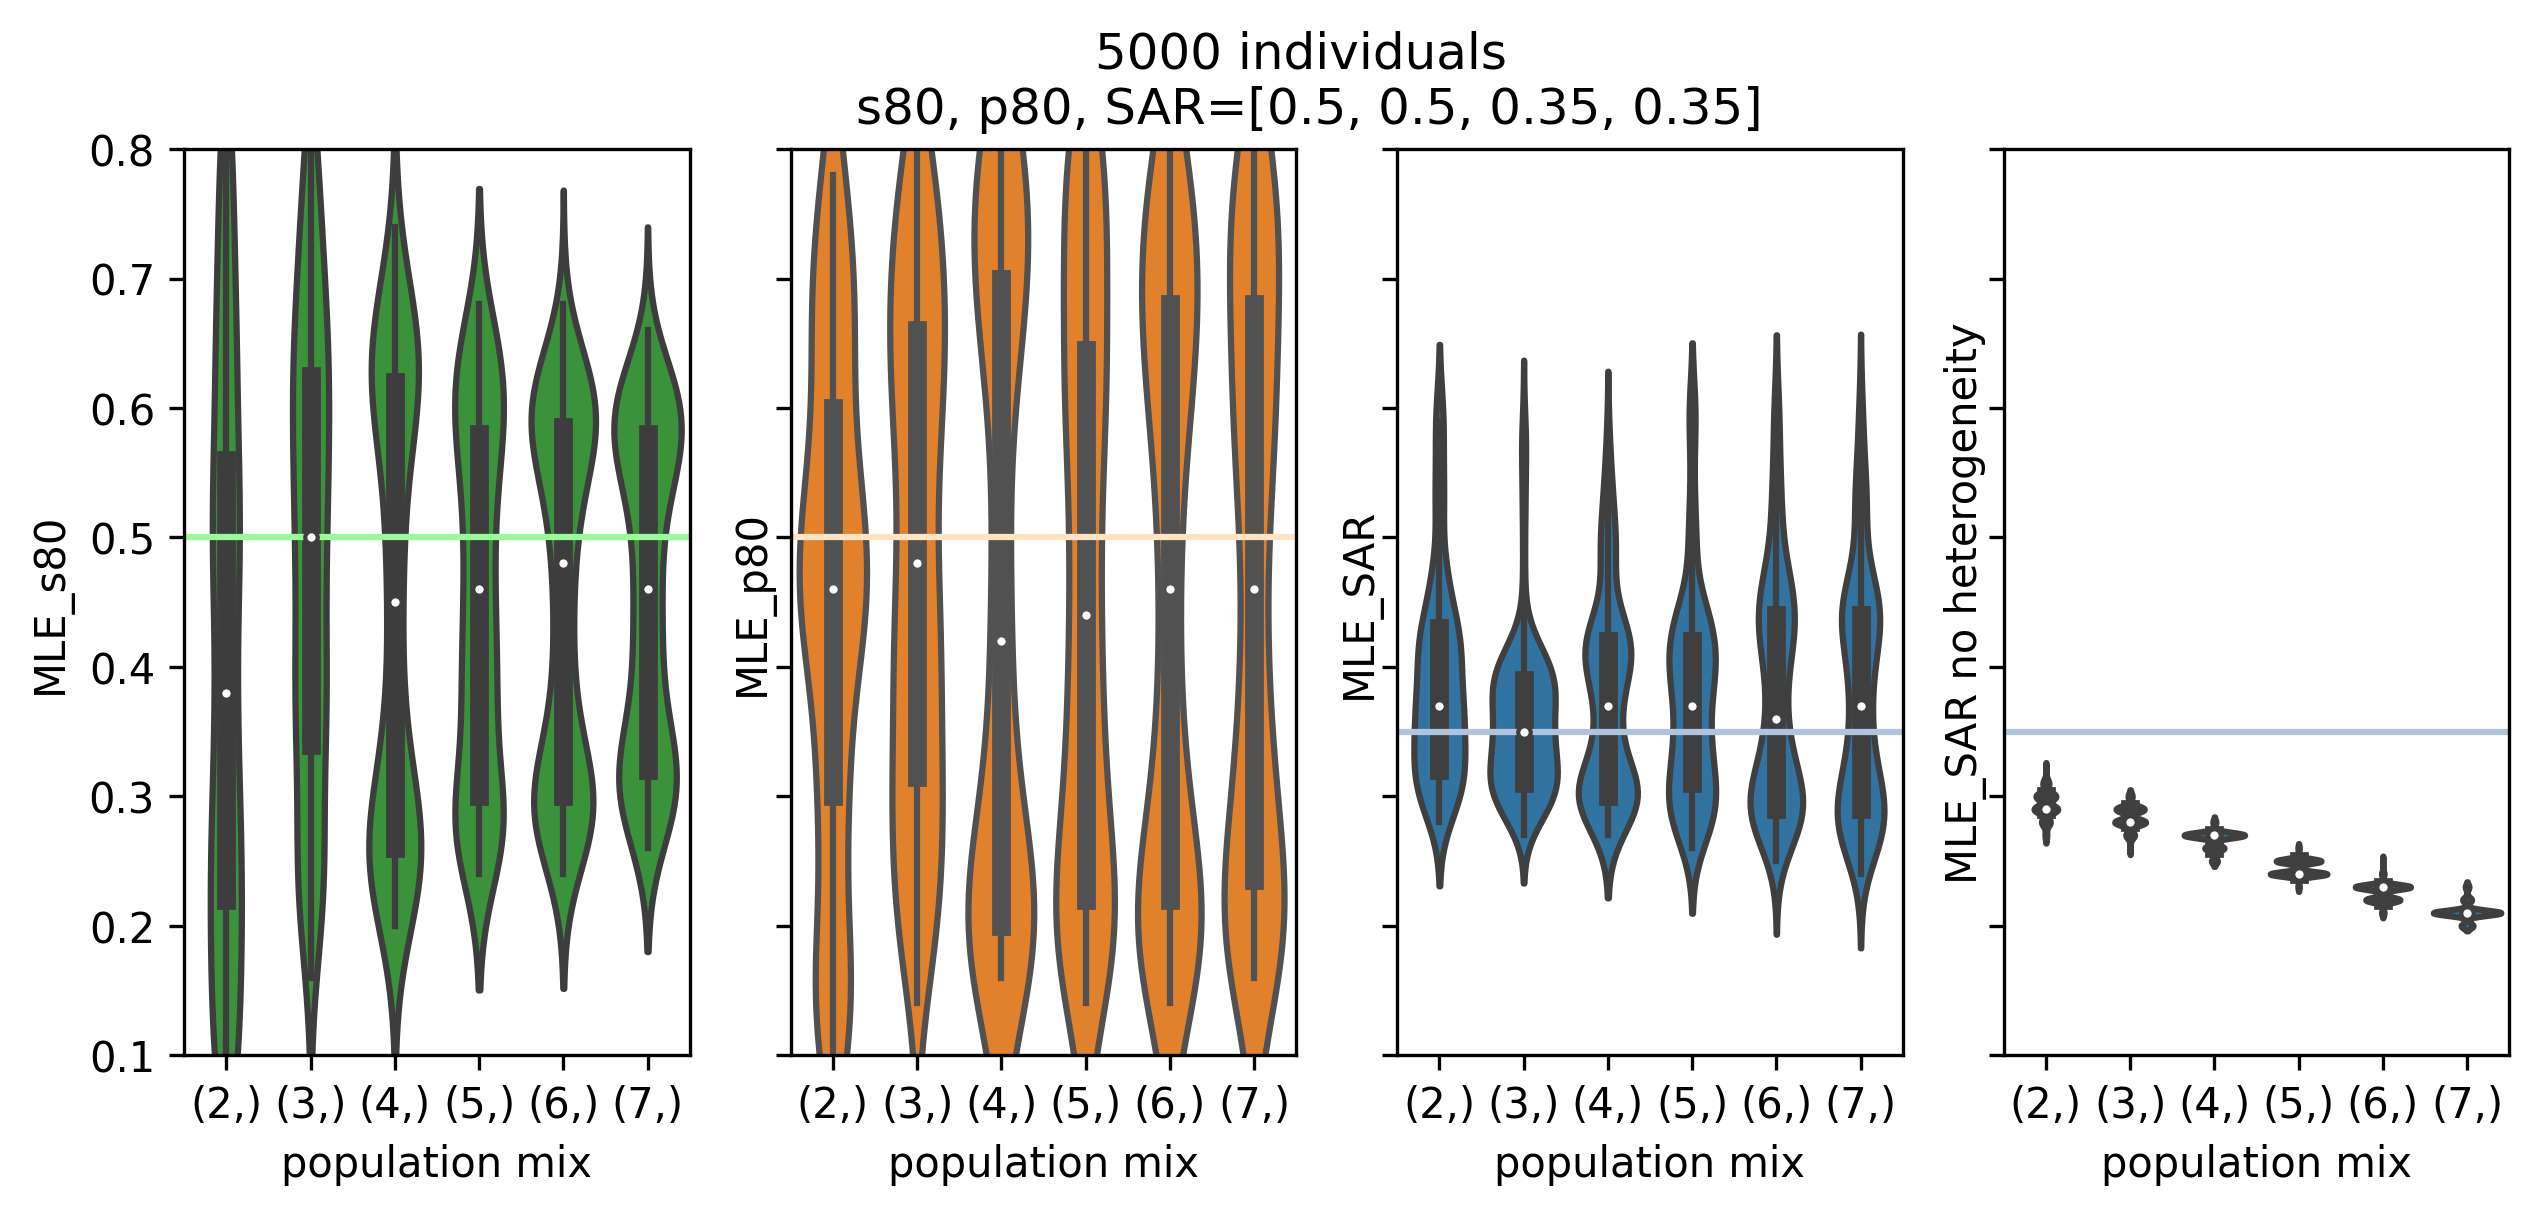

<Figure size 432x288 with 0 Axes>

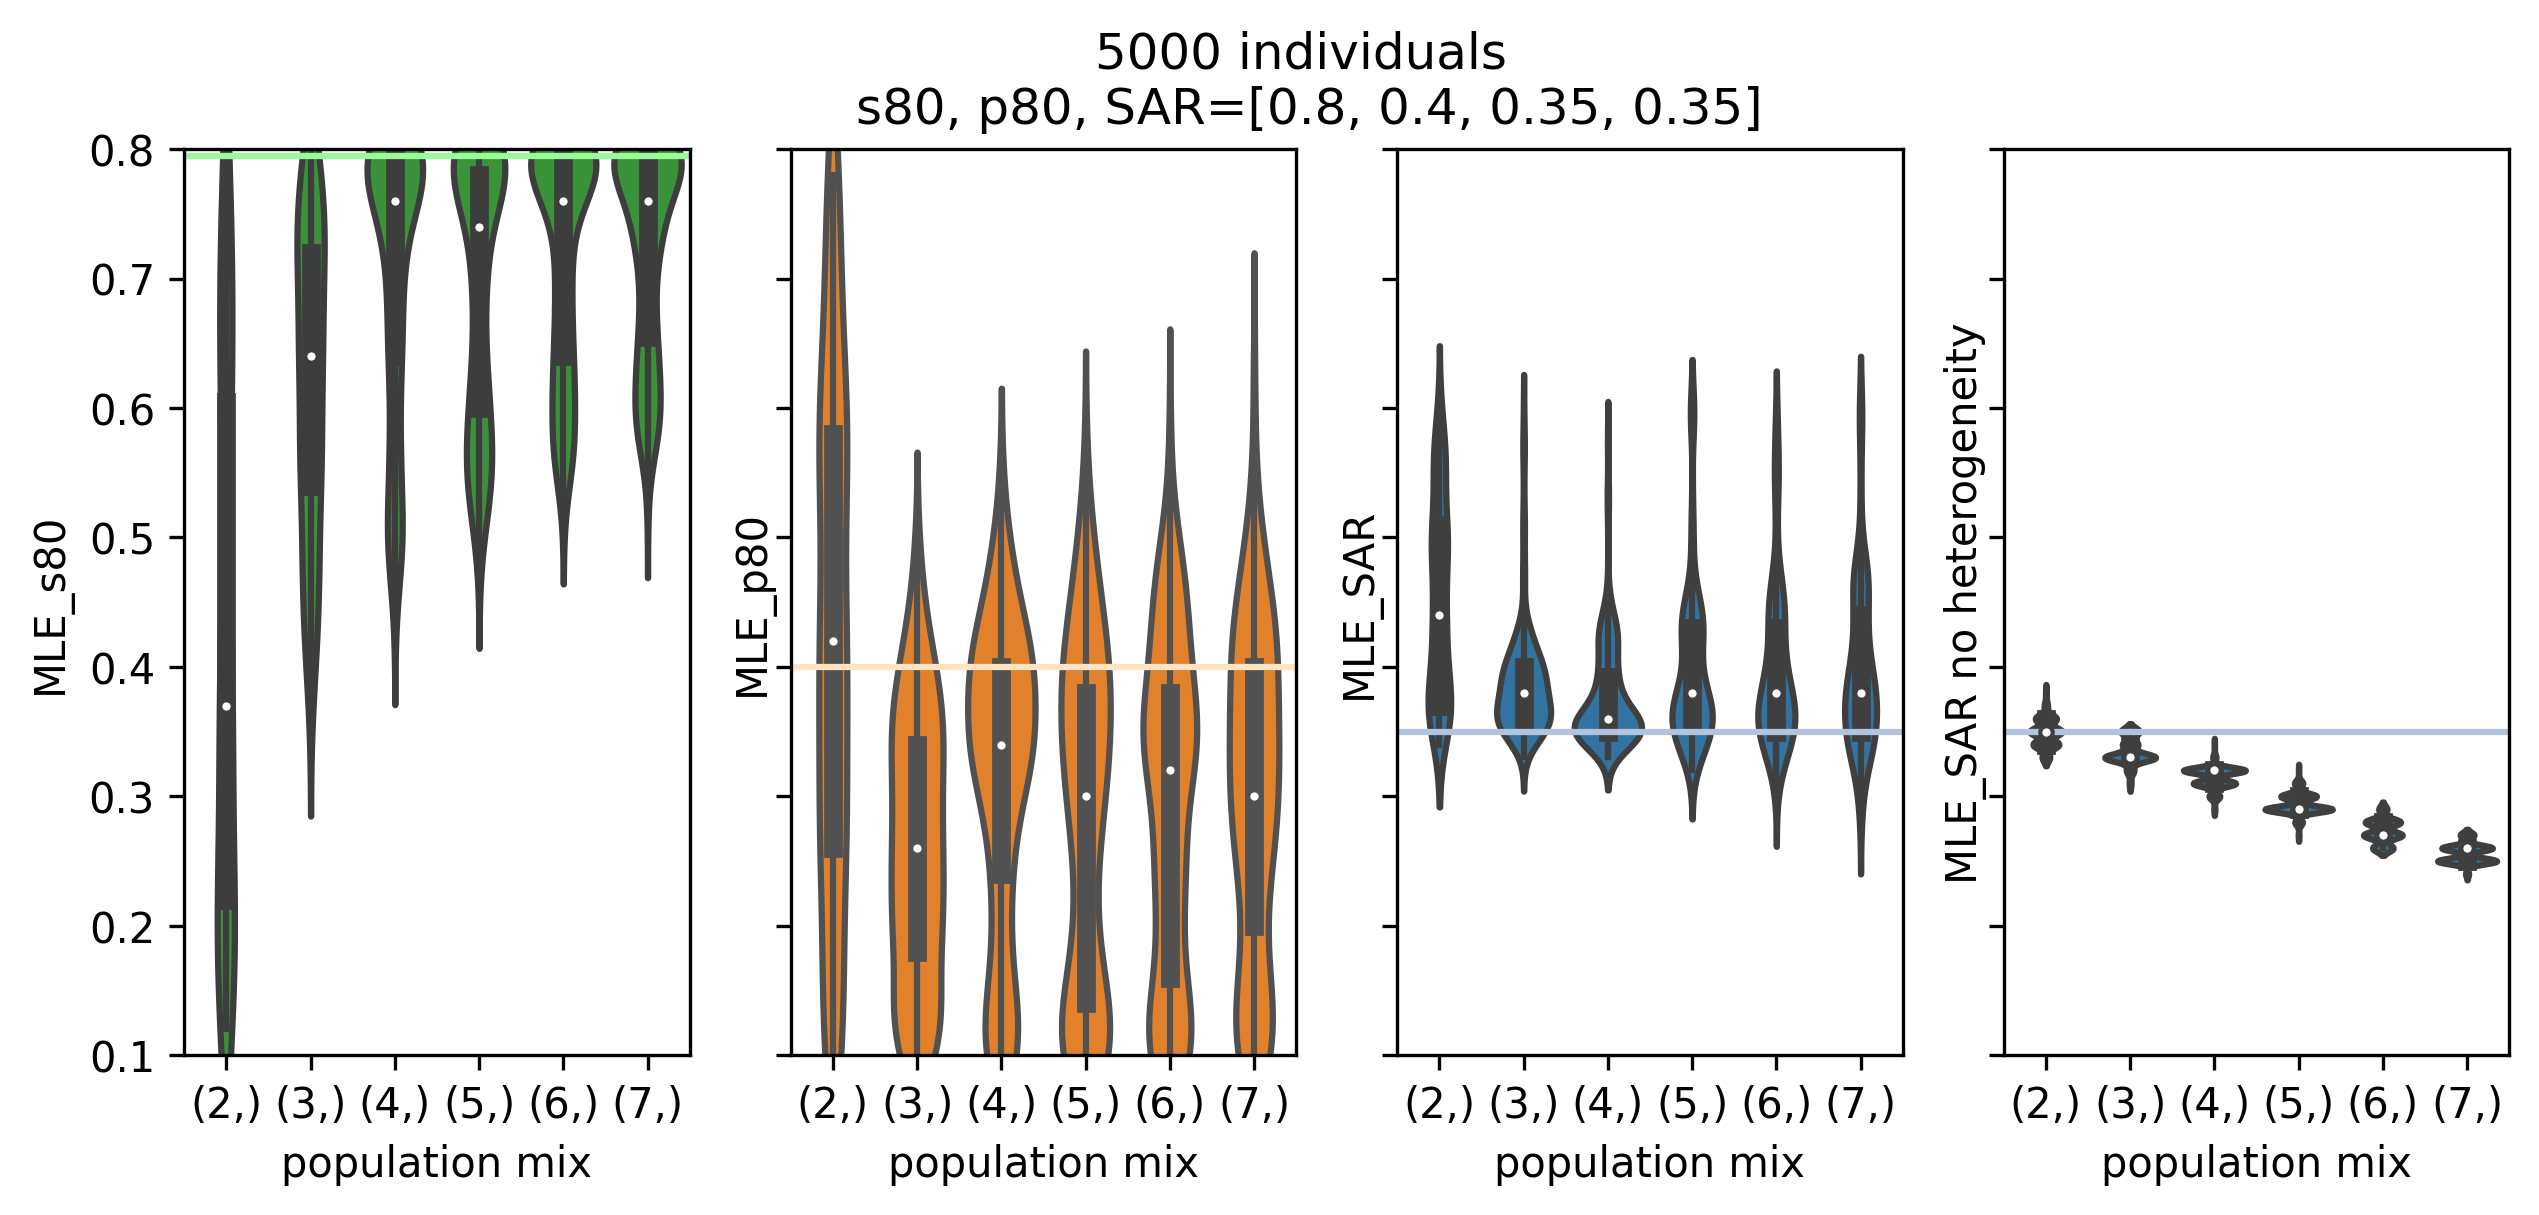

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
plt.close('all')

#hypothesis = 'SAR and susceptibility vary'
hypothesis = 'all'
fit_df = fits[hypothesis]

dpi = 300
save_figs = True

fig_sizes = {'small':(4,2.25), 'big':(10,4)}
chosen_size = 'big'

#%matplotlib agg
min_dict = {0.6: 0.3, 0.4:0.10, 0.5: 0.15, 0.8: 0.5}
max_dict = {0.6: 0.8, 0.4:0.65, 0.5: 0.8, 0.8: 0.8}
colors = ['tab:green', 'tab:orange', 'tab:blue', 'tab:blue']
axline_colors = ['palegreen', 'bisque', 'lightsteelblue', 'lightsteelblue']
xlabels = ['MLE\ns80', 'MLE\np80', 'MLE\nSAR', 'constant traits \nMLE for SAR']

drop_rules = {
    'population mix': ['Philippines', 'Mexico', (8,), 'America_census'],
}
#ordered_included_pops = ['America_UN', 'Guatemala', (8,)]#, (4,)]
#ordered_included_pops = ['Guatemala', (4,)]
ordered_included_pops = [(2,), (3,), (4,), (5,), (6,), (7,), (8,)]


def apply_drop_rules(df, drop_rules):
    new_df = df.copy()
    for column,exclusions in drop_rules.items():
        for exclusion in exclusions:
            new_df = new_df[new_df[column] != exclusion]
    return new_df

# Use the 'drop_rules' dictionary to forget any populations we don't care about to render a cleaned up figure
new_fit_df = apply_drop_rules(fit_df, drop_rules)
new_fit_df['population mix'] = new_fit_df['population mix'].astype(str)
null_hypothesis_fit_df = apply_drop_rules(fits['null hypothesis'], drop_rules)

# add the 'null hypothesis' SAR estimates into the dataframe so they'll be an accessible column in plotting
null_SARs = null_hypothesis_fit_df['MLE_SAR']
null_SARs.name = 'MLE_SAR no heterogeneity'
new_fit_df = pd.concat([new_fit_df, null_SARs], axis=1)

grouping=['written sample size', 'parameters']
for key,group in new_fit_df.groupby(grouping):
    sample_size, parameters = key
    # The true SAR is the same regardless of null hypothesis vs standard hypothesis
    # but the `key` in the index isn't long enough because it doesn't know that we care about the null hypothesis
    # so we add the true SAR as the line for "actual value" for the null hypothesis subplot
    parameters = list(parameters) + [parameters[-1]]
    plt.figure()
    fig, axes = plt.subplots(1,len(results.metadata.parameters)+1, dpi=dpi, sharey=True, figsize=fig_sizes[chosen_size])
    null_fit_group = null_hypothesis_fit_df.groupby(grouping).get_group(key)
    relevant_parameters = list(results.metadata.parameters) + ['SAR no heterogeneity']
    for param_index,parameter in enumerate(relevant_parameters):
        seaborn_parameter_name = parameter
        plt.suptitle(f"{sample_size} individuals \ns80, p80, SAR={parameters}")
        sns.violinplot(x='population mix', y=f'MLE_{seaborn_parameter_name}', data=group, ax=axes[param_index], orient="v", color=colors[param_index])
        if parameters[param_index] == 0.8:
            axes[param_index].axhline(0.795, color=axline_colors[param_index])
        else:
            axes[param_index].axhline(parameters[param_index], color=axline_colors[param_index])
        mi, ma = 0.1, 0.8
        axes[param_index].set_ylim(mi, ma)
    if save_figs:
        plt.savefig(os.path.join('/Users/thayer/covid_households/batched_figs', f'{key}' + '.jpg'))

The cell below will plot violins for all the parameters over a group of sample sizes.

     trial  MLE_s80  MLE_p80  MLE_SAR  sample size  population mix  \
0        0     0.40     0.22     0.19          986  America_census   
1        1     0.18     0.20     0.19          986  America_census   
2        2     0.20     0.22     0.20          986  America_census   
3        3     0.10     0.24     0.22          986  America_census   
4        4     0.02     0.04     0.24          986  America_census   
..     ...      ...      ...      ...          ...             ...   
995    995     0.16     0.60     0.21         9988  America_census   
996    996     0.20     0.80     0.20         9988  America_census   
997    997     0.26     0.72     0.19         9988  America_census   
998    998     0.10     0.60     0.22         9988  America_census   
999    999     0.12     0.56     0.21         9988  America_census   

          parameters p80_interval  s80_interval  SAR_interval  \
0    (0.2, 0.2, 0.2)  (0.02, 0.8)   (0.02, 0.8)   (0.11, 0.3)   
1    (0.2, 0.2, 0.2)  (0.02, 

<Figure size 432x288 with 0 Axes>

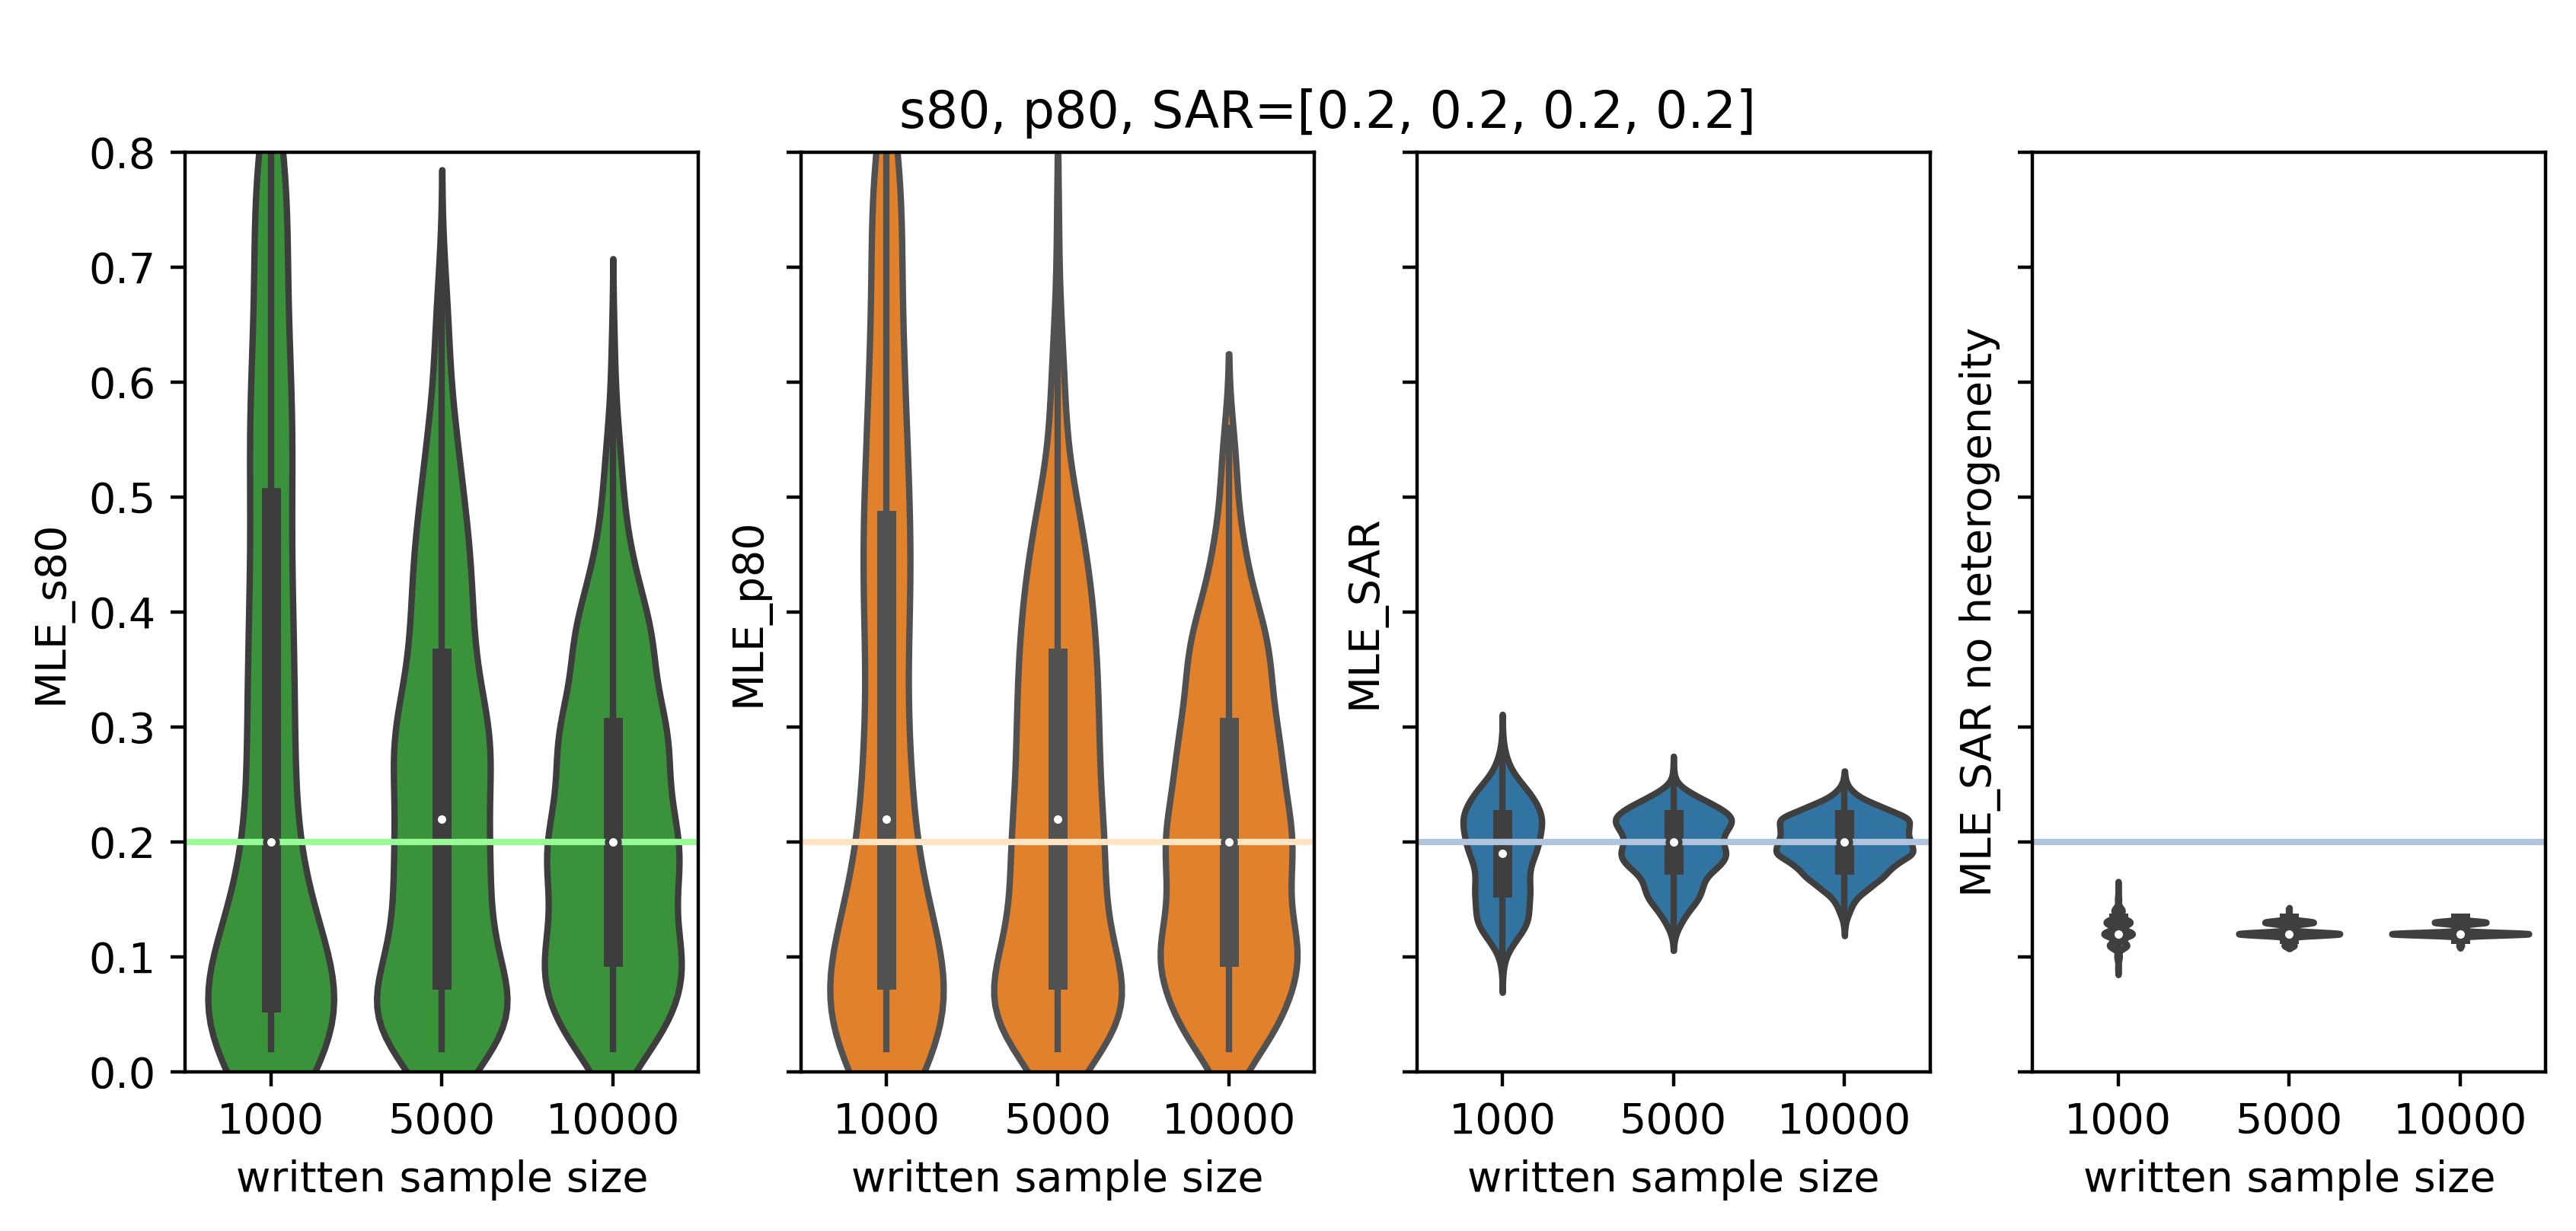

<Figure size 432x288 with 0 Axes>

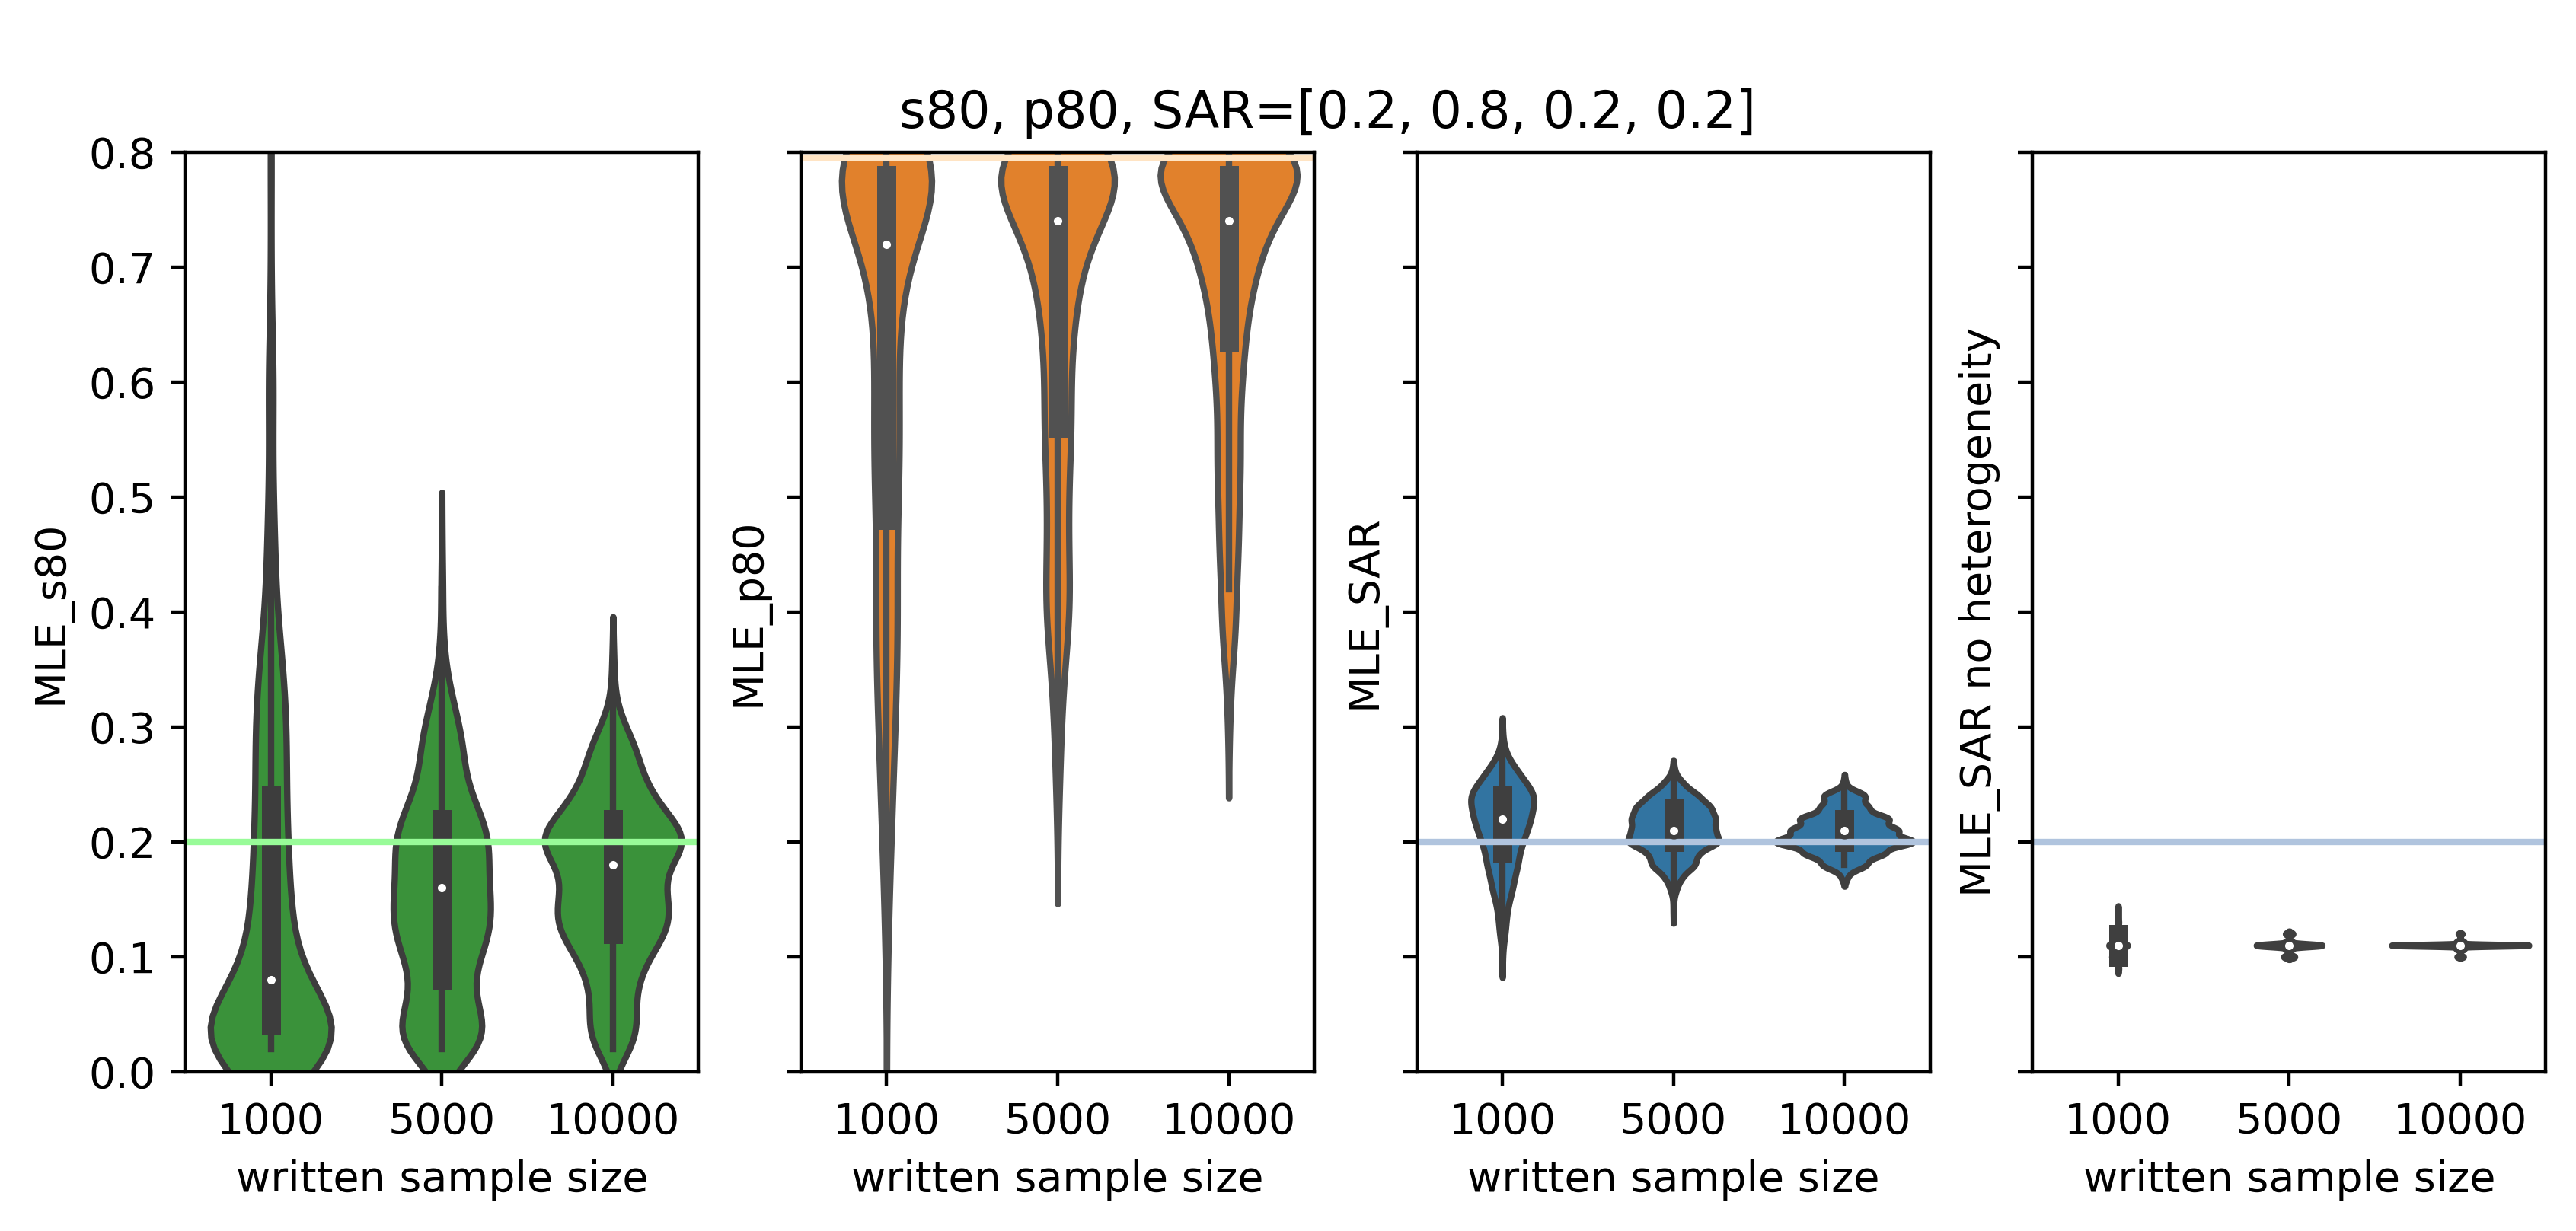

<Figure size 432x288 with 0 Axes>

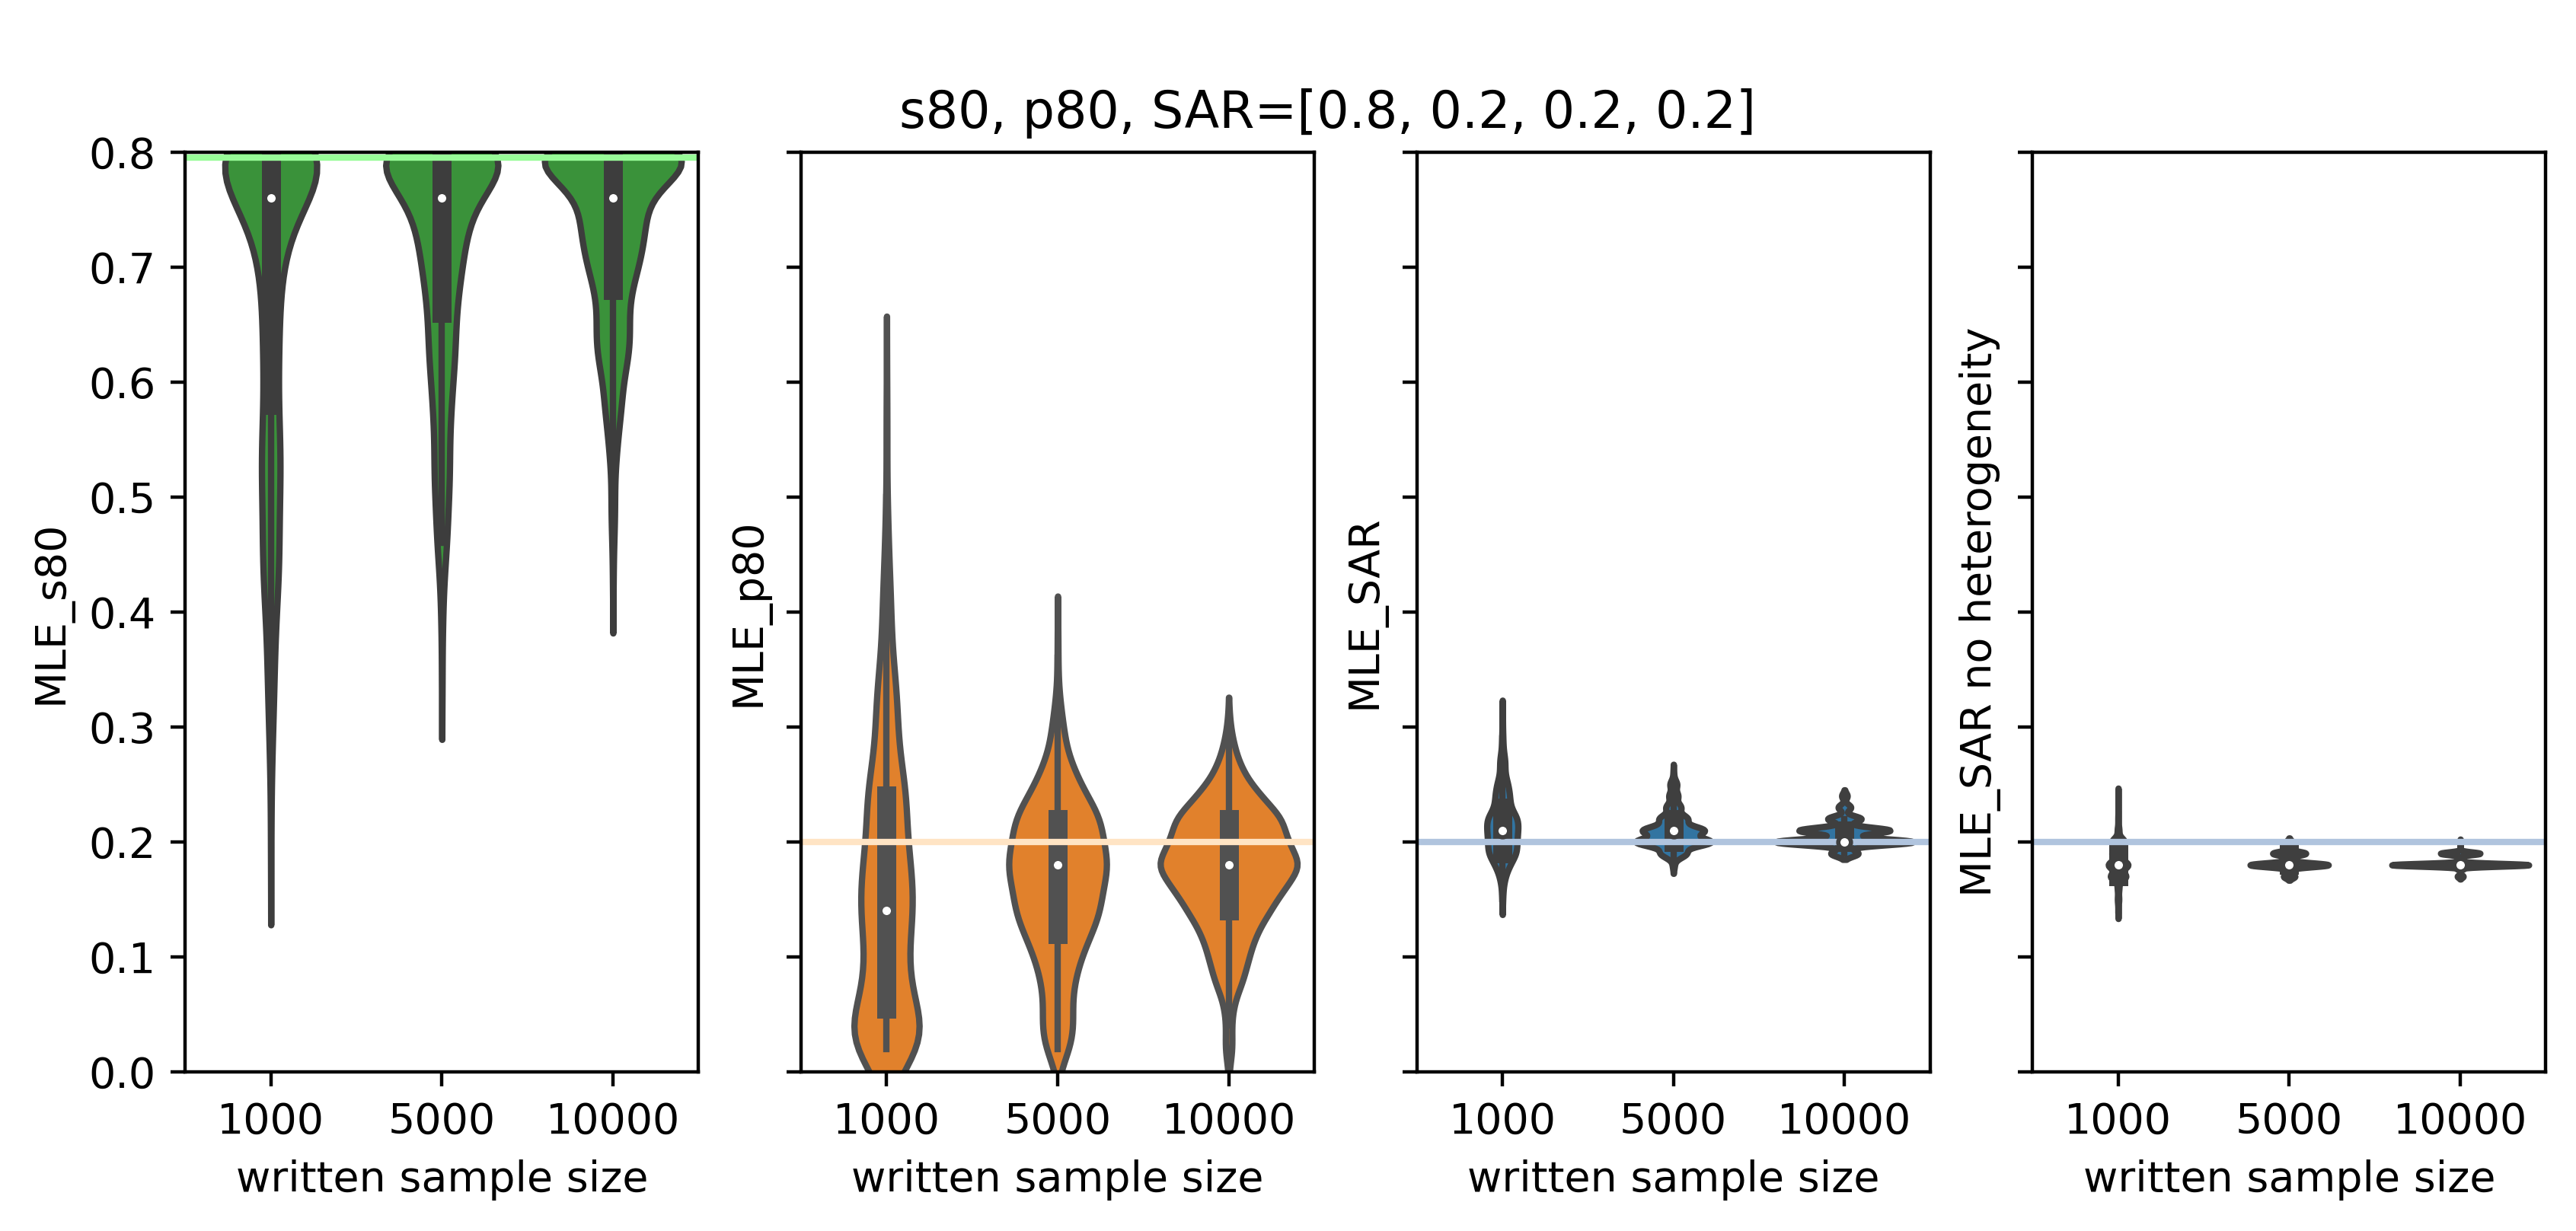

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
plt.close('all')

#hypothesis = 'SAR and susceptibility vary'
hypothesis = 'all'
fit_df = fits[hypothesis]

dpi = 400
save_figs = True

fig_sizes = {'small':(4,2.25), 'big':(10,4)}
chosen_size = 'big'

#%matplotlib agg
min_dict = {0.6: 0.3, 0.4:0.10, 0.5: 0.15, 0.8: 0.5}
max_dict = {0.6: 0.8, 0.4:0.65, 0.5: 0.8, 0.8: 0.8}
colors = ['tab:green', 'tab:orange', 'tab:blue', 'tab:blue']
axline_colors = ['palegreen', 'bisque', 'lightsteelblue', 'lightsteelblue']
xlabels = ['MLE\ns80', 'MLE\np80', 'MLE\nSAR', 'constant traits \nMLE for SAR']

chosen_pop = 'America_census'

def select_pop(df, chosen_pop):
    new_df = df.copy()
    new_df = new_df[new_df['population mix'] == chosen_pop]
    return new_df

# Choose only one population for plotting
new_fit_df = select_pop(fit_df, chosen_pop)
print(new_fit_df)
new_fit_df['population mix'] = new_fit_df['population mix'].astype(str)

# add the 'null hypothesis' SAR estimates into the dataframe so they'll be an accessible column in plotting
# but first select the population in the null hypothesis frequencies as well
null_hypothesis_fit_df = select_pop(fits['null hypothesis'], chosen_pop)
null_SARs = null_hypothesis_fit_df['MLE_SAR']
null_SARs.name = 'MLE_SAR no heterogeneity'
print(null_SARs)
new_fit_df = pd.concat([new_fit_df, null_SARs], axis=1)

grouping=['parameters']
if save_figs:
    import pyarrow as pa
    import pyarrow.parquet as pq
    new_fit_pq = pa.Table.from_pandas(new_fit_df)
    pq.write_table(new_fit_pq, os.path.join('/Users/thayer/covid_households/batched_figs/violin_df.parquet'))
    
for key,group in new_fit_df.groupby(grouping):
    print(group)
    parameters = key
    # The true SAR is the same regardless of null hypothesis vs standard hypothesis
    # but the `key` in the index isn't long enough because it doesn't know that we care about the null hypothesis
    # so we add the true SAR as the line for "actual value" for the null hypothesis subplot
    parameters = list(parameters) + [parameters[-1]]
    plt.figure()
    fig, axes = plt.subplots(1,len(results.metadata.parameters)+1, dpi=dpi, sharey=True, figsize=fig_sizes[chosen_size])
    null_fit_group = null_hypothesis_fit_df.groupby(grouping).get_group(key)
    relevant_parameters = list(results.metadata.parameters) + ['SAR no heterogeneity']
    for param_index,parameter in enumerate(relevant_parameters):
        seaborn_parameter_name = parameter
        plt.suptitle(f"\ns80, p80, SAR={parameters}")
        sns.violinplot(x='written sample size', y=f'MLE_{seaborn_parameter_name}', data=group, ax=axes[param_index], orient="v", color=colors[param_index])
        if parameters[param_index] == 0.8:
            axes[param_index].axhline(0.795, color=axline_colors[param_index])
        else:
            axes[param_index].axhline(parameters[param_index], color=axline_colors[param_index])
        mi, ma = 0.0, 0.8
        axes[param_index].set_ylim(mi, ma)
    if save_figs:
        plt.savefig(os.path.join('/Users/thayer/covid_households/batched_figs', f'{key}' + '.jpg'))

In [ ]:
relevant_data = fit_df[(fit_df['population mix'] == (4,5,6,7,8)) & (fit_df['parameters'] == (0.4, 0.8, 0.25))]

import matplotlib.pyplot as plt
import seaborn as sns
sns.catplot(x='sample size', y='MLE_p80', kind='swarm', data=relevant_data, s=3)
plt.ylim((0.1, 0.8))

In [ ]:
null_fits = null_fit_df['MLE_SAR'].copy()
null_fits.name = 'No traits \n MLE for SAR'
version_2_df = pd.concat([fit_df, null_fits], axis=1)

params = ['population mix', 'sample size', 'parameters']
for k,g in version_2_df.groupby(params):
    data = g.drop(params, axis=1)
    plt.figure(dpi=800)
    fig = sns.violinplot(data=data)
    fig.set_ylim(0.1, 0.8)
    plt.savefig(os.path.join('/Users/thayer/covid_households/batched_figs', 'v2' + f'{k}' + '.jpg'))
    break

In [ ]:
means = fit_df.groupby(['population mix', 'sample size', 'parameters']).mean()
stds = fit_df.groupby(['population mix', 'sample size', 'parameters']).std()
stds.columns = ['STD_' + s for s in stds.columns]

statistics = pd.concat([means, stds], axis=1)
with open('/Users/thayer/covid_households/batched_figs/stats.csv', 'w') as f:
    statistics.to_csv(f)

In [ ]:
stds.sort_values(by='STD_MLE_s80')
with open('/Users/thayer/covid_households/batched_figs/stds.csv', 'w') as f:
    stds.to_csv(f)

with open('/Users/thayer/covid_households/batched_figs/means.csv', 'w') as f:
    means.to_csv(f)

# Power calculation

In [17]:
import likelihood

def SAR_pvalue_for_trial(baseline_logl, comparison_logl, for_increase=False):
    baseline_posterior = np.exp(baseline_logl.sort_values(ascending=False)-baseline_logl.max())
    baseline_posterior = baseline_posterior/baseline_posterior.sum()
    # we groupby 'SAR' and sum so that we can capture all the probability at that SAR — regardless of other parameter values
    baseline_probability_over_sars = baseline_posterior.groupby('SAR').sum()

    comparison_posterior = np.exp(comparison_logl.sort_values(ascending=False)-comparison_logl.max())
    baseline_SAR_confidence_interval = likelihood.confidence_interval_from_confidence_mask(likelihood.confidence_mask_from_logl(baseline_logl, percentiles=(0.9,)), key='SAR')
    comparison_SAR_confidence_interval = likelihood.confidence_interval_from_confidence_mask(likelihood.confidence_mask_from_logl(comparison_logl, percentiles=(0.9,)), key='SAR')
    comparison_posterior = comparison_posterior/comparison_posterior.sum()
    probability_over_sars = comparison_posterior.groupby('SAR').sum()

    # use the probability surface to generate imagined MLEs
    sample1 = np.random.choice(baseline_probability_over_sars.index, 10000, p=baseline_probability_over_sars)
    sample2 = np.random.choice(probability_over_sars.index, 10000, p=probability_over_sars)

    # what fraction of the time does the first group have a increased/decreased SAR compared to the second group
    if for_increase:
        pvalue = np.count_nonzero((sample2-sample1) > 0)/len(sample1)
    else:
        pvalue = np.count_nonzero((sample2-sample1) < 0)/len(sample1)

    return pvalue, baseline_SAR_confidence_interval, comparison_SAR_confidence_interval

interval_notes = defaultdict(list)

def calculate_power_over_SAR_range(population, trials, basline_parameters, sar_range, hypotheses, for_increase=False):
    pvalue_sets = []
    for hypothesis_name in hypotheses.keys():
        frequencies = frequencies_by_hypothesis[hypothesis_name]
        for sar in sar_range:
            # replace baseline sar with target sar
            parameters = list(basline_parameters)
            parameters[results.metadata.parameters.index('SAR')] = float(f'{sar:0.3f}')
            parameters = tuple(parameters)
            print(parameters)
   
            # get imagined infections from the simulated data at the baseline parameters to establish the probability surface for the MLE w.r.t. the baseline
            samples = results.resample(basline_parameters, population, trials=trials)
            baseline_logl = likelihood.logl_from_frequencies_and_counts(frequencies, samples['count'], results.metadata.parameters)

            # get imagined infections from the simulated data at the comparison parameters to establish the probability surface for the MLE w.r.t. the comparison point
            samples = results.resample(parameters, population, trials=trials)
            logl = likelihood.logl_from_frequencies_and_counts(frequencies, samples['count'], results.metadata.parameters)

            comparison_logl_grouped = logl.groupby('trial')
            single_trial_pvalues = []
            for key, baseline_logl_trial_group in baseline_logl.groupby('trial'):
                comparison_logl_trial_group = comparison_logl_grouped.get_group(key)
                pvalue, baseline_SAR_confidence_interval, comparison_SAR_confidence_interval = SAR_pvalue_for_trial(baseline_logl_trial_group, comparison_logl_trial_group, for_increase=for_increase)
                single_trial_pvalues.append(pvalue)
            #index = pd.MultiIndex.from_product([sar, hypothesis_name, list(range(trials))], names=['SAR', 'hypothesis', 'trial'])
            #pvalue_sets.append(pd.Series(data=single_trial_pvalues, index=index))
            pvalue_sets.append(pd.DataFrame({'pvalue':single_trial_pvalues, 'SAR':sar, 'hypothesis':hypothesis_name, 'trial':list(range(trials))}))
    df_piece = pd.concat(pvalue_sets)
    return df_piece


In [18]:
sar_range = np.linspace(0.10, 0.20, 2)
trials = 2000

baseline_parameter_sets = [
    (0.8, 0.8, 0.3),
    #(0.7, 0.7, 0.4),
    #(0.6, 0.6, 0.4),
    (0.5, 0.5, 0.3),
    #(0.4, 0.4, 0.4),
    (0.2, 0.2, 0.3),
]

populations = [
    #{8:25},
    {4:50},
    {2:100},
    #{8:125},
    {2:500},
    #{2:33, 4:17, 8:8},
    #{3:83, 4:63, 5:50, 6:42},
    #{4:83, 6:56, 8:42}
    {4:250},
]

hypotheses = {
    'all': ['s80', 'p80', 'SAR'],
    #'SAR and infectivity vary': ['p80', 'SAR'],
    'null hypothesis': ['SAR'],
}
frequencies_by_hypothesis = {k: restrict_parameters(results, included_parameters) for k,included_parameters in hypotheses.items()}

power_pvalue = 0.9

pvalue_dfs = []
from collections import defaultdict
power_dfs = defaultdict(list)

pvalue_df_pieces = []
for baseline_parameters in baseline_parameter_sets:
    for population in populations:
        pvalue_df_piece = calculate_power_over_SAR_range(population, trials, baseline_parameters, sar_range, hypotheses)
        pvalue_df_piece['parameters'] = str(baseline_parameters)
        pvalue_df_piece['population'] = str(population)
        print(pvalue_df_piece)
        pvalue_df_pieces.append(pvalue_df_piece)
        #pvalue_df = pd.DataFrame(pvalues_for_decrease, index=[float(f'{sar:0.3f}') for sar in sar_range]).transpose()
        #pvalue_dfs.append(pvalue_df)
        #power = ((pvalue_df > power_pvalue).sum()/trials)
        #power.name = str(population)
        #power_dfs[baseline_parameters].append(power)
pvalue_df = pd.concat(pvalue_df_pieces)
pvalue_df = pvalue_df.set_index(['population', 'parameters', 'hypothesis', 'SAR', 'trial']).squeeze().unstack([0,1,2,3])
pvalue_df = (pvalue_df > 0.9).sum()/trials
pvalue_df.name = 'power'

(0.8, 0.8, 0.1)
(0.8, 0.8, 0.2)
(0.8, 0.8, 0.1)
(0.8, 0.8, 0.2)
      pvalue  SAR       hypothesis  trial       parameters population
0     0.9976  0.1              all      0  (0.8, 0.8, 0.3)    {4: 50}
1     1.0000  0.1              all      1  (0.8, 0.8, 0.3)    {4: 50}
2     0.9972  0.1              all      2  (0.8, 0.8, 0.3)    {4: 50}
3     0.9978  0.1              all      3  (0.8, 0.8, 0.3)    {4: 50}
4     0.9946  0.1              all      4  (0.8, 0.8, 0.3)    {4: 50}
...      ...  ...              ...    ...              ...        ...
1995  0.9993  0.2  null hypothesis   1995  (0.8, 0.8, 0.3)    {4: 50}
1996  0.9886  0.2  null hypothesis   1996  (0.8, 0.8, 0.3)    {4: 50}
1997  0.9999  0.2  null hypothesis   1997  (0.8, 0.8, 0.3)    {4: 50}
1998  0.9116  0.2  null hypothesis   1998  (0.8, 0.8, 0.3)    {4: 50}
1999  0.8957  0.2  null hypothesis   1999  (0.8, 0.8, 0.3)    {4: 50}

[8000 rows x 6 columns]
(0.8, 0.8, 0.1)
(0.8, 0.8, 0.2)
(0.8, 0.8, 0.1)
(0.8, 0.8, 0.2)
      p

In [19]:
pvalue_df = pvalue_df.reset_index().set_index(['population', 'SAR', 'parameters', 'hypothesis',]).squeeze().sort_index()

In [22]:
pvalue_df.unstack([1,2]).round(2)#.to_excel('../batched_figs/powers/powers_2000_trials_SAR_30_08_16.xlsx')

SAR                                    0.1                                  \
parameters                 (0.2, 0.2, 0.3) (0.5, 0.5, 0.3) (0.8, 0.8, 0.3)   
population hypothesis                                                        
{2: 100}   all                        0.90            0.91            0.95   
           null hypothesis            0.97            0.98            0.99   
{2: 500}   all                        1.00            1.00            1.00   
           null hypothesis            1.00            1.00            1.00   
{4: 250}   all                        1.00            1.00            0.63   
           null hypothesis            1.00            1.00            1.00   
{4: 50}    all                        0.94            0.92            0.67   
           null hypothesis            0.99            1.00            1.00   

SAR                                    0.2                                  
parameters                 (0.2, 0.2, 0.3) (0.5, 0.5, 0.3) (0.8, 0.8, 0.3)  
population hypothesis                                                       
{2: 100}   all                        0.30            0.30            0.32  
           null hypothesis            0.55            0.58            0.60  
{2: 500}   all                        0.35            0.35            0.39  
           null hypothesis            0.97            0.98            0.98  
{4: 250}   all                        0.67            0.64            0.48  
           null hypothesis            0.99            1.00            1.00  
{4: 50}    all                        0.42            0.40            0.38  
           null hypothesis            0.60            0.70            0.84

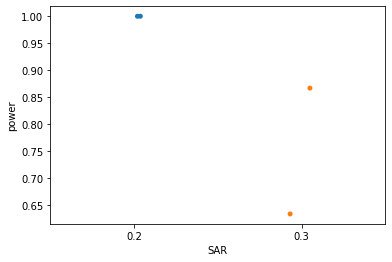

In [138]:
ax = sns.stripplot(y='power', x='SAR', data=df.reset_index())

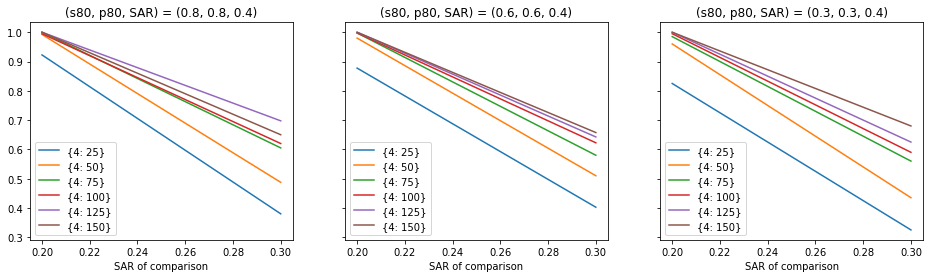

In [30]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, len(power_dfs.keys()), figsize=(16,4), sharey=True)
if not isinstance(ax, np.ndarray):
    ax = [ax]
i = 0
for baseline_parameters, powers in power_dfs.items():
    power_df = pd.concat(powers, axis=1)
    power_df.plot(ax=ax[i])
    ax[i].set_xlabel('SAR of comparison')
    ax[i].set_title(f'(s80, p80, SAR) = {baseline_parameters}')

    i += 1
plt.savefig('../batched_figs/power_calculations.png', dpi=300)

In [23]:
for baseline_parameters, powers in power_dfs.items():
    power_df = pd.concat(powers, axis=1)
    break

In [28]:
power_df['{4: 100}']

0.20    1.0000
0.22    0.9925
0.24    0.9900
0.26    0.9425
0.28    0.8350
0.30    0.6075
0.32    0.3825
0.34    0.2150
0.36    0.0600
0.38    0.0225
0.40    0.0000
Name: {4: 100}, dtype: float64

In [64]:
pvalue_df = pd.DataFrame(pvalues_for_increase, index=[float(f'{sar:0.3f}') for sar in sar_range]).transpose()
pvalue_df

,0.20,0.24,0.28,0.32,0.36,0.40
0,0.9999,0.9343,0.9297,0.9129,0.7861,0.1645
1,0.9929,0.9743,0.9952,0.7128,0.9560,0.8315
2,1.0000,0.9951,0.9720,0.9366,0.9434,0.3768
3,0.9999,0.9999,0.9841,0.9106,0.8739,0.2908
4,1.0000,0.9966,0.9728,0.9860,0.4669,0.6460
...,...,...,...,...,...,...
495,0.9999,0.9932,0.9282,0.7555,0.2923,0.7249
496,0.9999,0.9994,0.9263,0.9799,0.4493,0.4249
497,0.9999,0.9989,0.9632,0.9092,0.5181,0.5397
498,1.0000,0.9977,0.8480,0.8308,0.6520,0.7372


In [65]:
power90 = ((pvalue_df > 0.90).sum()/trials)#.plot()
power90.name = 'power p=0.9'

In [66]:
power95 = (pvalue_df > 0.95).sum()/trials
power95.name = 'power p=0.95'

Text(0.5, 0, 'SAR in heightened group')

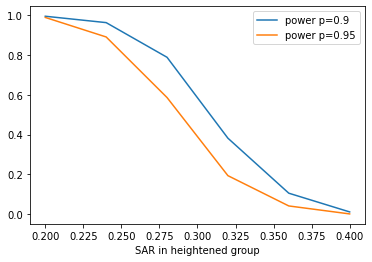

In [67]:
import matplotlib.pyplot as plt
power_df = pd.concat([power90, power95], axis=1)
power_df.plot()
plt.xlabel('SAR in heightened group')

In [ ]:
brendan_fit_df = pd.concat(brendan_fit_dfs)

In [ ]:
clusters = []
for k,g in brendan_fit_df.groupby('parameters'):
    clusters.append(g)

In [ ]:
((clusters[0]['MLE_SAR'] + 0.1) < clusters[1]['MLE_SAR']).value_counts()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
plt.close('all')
#%matplotlib agg
min_dict = {0.6: 0.3, 0.4:0.10, 0.5: 0.15, 0.8: 0.5}
max_dict = {0.6: 0.8, 0.4:0.65, 0.5: 0.8, 0.8: 0.8}
colors = ['tab:green', 'tab:orange', 'tab:blue']
axline_colors = ['palegreen', 'bisque', 'lightsteelblue']
xlabels = ['MLE\ns80', 'MLE\np80', 'MLE\nSAR', 'constant traits \nMLE for SAR']
for k,g in brendan_fit_df.groupby(['population mix', 'sample size', 'parameters']):
    plt.figure()
    fig, axes = plt.subplots(1,3, dpi=800, sharey=True)
    print(k)
    print(g.mean())
    population_mix, sample_size, parameters = k
    plt.suptitle(f"{sample_size} individuals equally mixed among size {population_mix} hhs. \ns80, p80, SAR={parameters}")
    i = 0
    for c in g.columns:
        if 'MLE' not in c:
            continue
        if 's80' in c or 'p80' in c:
            parameter_index = 0 if 's80' in c else 1
            mi, ma = 0.1, 0.8
            axes[i].set_ylim(mi, ma)
        if 'SAR' in c:
            pass
            #axes[i].set_ylim(0.1, 0.5)
            axes[i].set_ylim(0.1, 0.8)
        if parameters[i] == 0.8:
            axes[i].axhline(0.795, color=axline_colors[i])
        else:
            axes[i].axhline(parameters[i], color=axline_colors[i])
        sns.violinplot(y=c, data=g, ax=axes[i], orient="v", color=colors[i])
        axes[i].set(xlabel=xlabels[i], ylabel='')
        i += 1

    fig.tight_layout()
    plt.savefig(os.path.join('/Users/thayer/covid_households/batched_figs/brendan', f'{k}' + '.jpg'))
    #break
    #input()

In [ ]:
import numpy as np
expected_s80s = np.linspace(0.1, 0.8, 36)
expected_p80s = np.linspace(0.1, 0.8, 36)
expected_SARs = np.linspace(0.15, 0.40, 26)

decimal_places = 3

for s80, p80, SAR in zip(expected_s80s, expected_p80s, expected_SARs):
    # touch everything in the convex area that we expect to exist
    results.df.loc[float(f"{s80:.{decimal_places}f}"), float(f"{p80:.{decimal_places}f}"), float(f"{SAR:.{decimal_places}f}")]
    #print(results.df.loc[float(f"{s80:.{decimal_places}f}"), float(f"{p80:.{decimal_places}f}"), float(f"{SAR:.{decimal_places}f}")])
    #break